# Tarea 2 - Parte 1
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from itertools import cycle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import math
import time
np.random.seed(7) ## semilla

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

### a) Función que carga los datos, los divide en 1500 de entrenamiento y 500 de pruebas, y escalado de datos para trabajar con redes recurrentes.

In [3]:
## Función que carga los datos y escala
def data(name_f, num):    
    # Leer archivo CSV extrayendo la columna 1, y luego guardando solo los primeros num datos
    dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:num]
    
    # Transforma todos los datos a tipo float32
    dataframe[:] = dataframe[:].astype('float32')
    
    # en df_train guarda los primeros 1500 valores --- posicion 0 hasta 1500 y
    # en df_test guarda los restantes  500 valores --- posicion 1500 hasta el final
    df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
    
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled  = scaler.transform(df_test)
    return scaler, dataframe, stream_train_scaled, stream_test_scaled

** Utilizando la función data(name_f,num), definida anteriormente**

In [4]:
name_f = "time_series_data.csv"
num = 2000
scaler, dataframe,stream_train_scaled,stream_test_scaled = data(name_f,num)

##para tener una copia de los datos originales.
stream_train_scaled_Orig = np.copy(stream_train_scaled) 
stream_test_scaled_Orig = np.copy(stream_test_scaled) 

**Verificando la distribución de los datos**

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
count,2000.000000
mean,11.148250
std,4.194983
min,0.000000
25%,8.100000
50%,11.000000
75%,14.000000
max,26.299999


,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,10.0


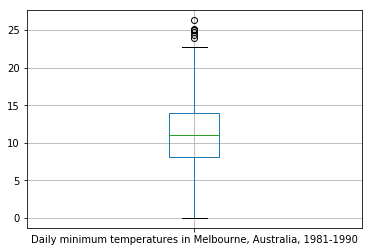

In [5]:
##  Describiendo el dataframe
dataframe.describe()
dataframe.mode()
dataframe.boxplot()

Datos de entrenamiento escalados
Max: 1.0
Min: 0.0
Len: 1500
Datos de prueba escalados
Max: 0.8517111
Min: 0.011406845
Len: 500


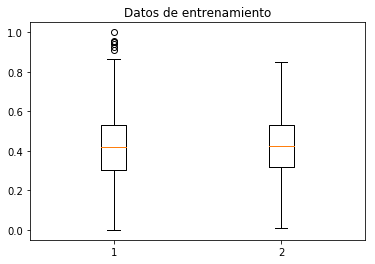

In [6]:
## Para los datos de entrenamiento y prueba escalados

print("Datos de entrenamiento escalados")
print("Max: %s" % (stream_train_scaled.max()))
print("Min: %s" % (stream_train_scaled.min()))
print("Len: %s" % (len(stream_train_scaled)))

print("Datos de prueba escalados")
print("Max: %s" % (stream_test_scaled.max()))
print("Min: %s" % (stream_test_scaled.min()))
print("Len: %s" % (len(stream_test_scaled)))

scaled_data = [stream_train_scaled,stream_test_scaled]
_ = plt.title("Datos de entrenamiento")
_ = plt.boxplot(scaled_data)

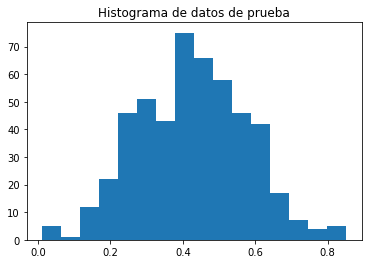

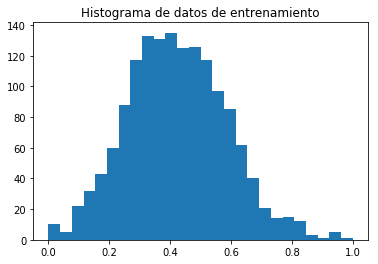

In [7]:
hist, bin_edges = np.histogram(stream_test_scaled,bins='auto')
_ = plt.hist(stream_test_scaled, bins=bin_edges)
_ = plt.title("Histograma de datos de prueba")
plt.show()

hist, bin_edges = np.histogram(stream_train_scaled,bins='auto')
_ = plt.hist(stream_train_scaled, bins=bin_edges)
_ = plt.title("Histograma de datos de entrenamiento")
plt.show()

** Comentarios ** De acuerdo a la estadística descriptiva y gráficos se observa que los dataset creados tienen una distribución de datos muy similar.

### b)  Función que recibe una secuencia de valores y la transforma en dos arreglos dataX (input) y dataY (targets) donde el número de características de la matriz de entrada (columnas) es el número de tiempos que se considera como información (lag).

### Para la predicción del tiempo siguiente se utilizan los últimos períodos de tiempo anterior.

**lag es el número de períodos los que serán usados para la predicción.**

In [8]:
def create_dataset(dataset,lag=1):
    # filas
    m = len(dataset) - lag    
    # columnas
    n = lag + 1    
    data = np.array( [ dataset[x:x+lag+1].flatten() for x in range(0, m) ] )
    dataY=data[:,lag]
    dataX=np.delete(data,lag,1)
    return dataX, dataY

In [9]:
## Ejemplo según enunciado
dset_prueba = np.array([[20.7], [17.9], [18.8], [14.6], [15.8], [15.8], [10.1]])
dataX, dataY = create_dataset(dset_prueba, 3)

print("dataX %s\n"  % (dataX))
print("dataY %s"  % (dataY))

dataX [[20.7 17.9 18.8]
 [17.9 18.8 14.6]
 [18.8 14.6 15.8]
 [14.6 15.8 15.8]]

dataY [14.6 15.8 15.8 10.1]


### c) Utilizando la función anterior se generan los  conjuntos de prueba y entrenamiento

In [10]:
def createData_TrainTest(_lag_, _train_scaled_Orig_, _test_scaled_Orig_):
    _trainX_, _trainY_ = create_dataset(_train_scaled_Orig_, _lag_)
    _testX_, _testY_   = create_dataset(_test_scaled_Orig_, _lag_)
    
    #_trainX_ = np.reshape(_trainX_, (_trainX_.shape[0], _trainX_.shape[1],1)) ## reshape de considerando la eleeción opción i)
    #_testX_  = np.reshape(_testX_, (_testX_.shape[0],_testX_.shape[1],1))
    return _trainX_, _trainY_, _testX_, _testY_

def print_format(_trainX_, _trainY_, _testX_, _testY_):
    print("TrainX %s" % str(_trainX_.shape))  
    print("TrainY %s" % str(_trainY_.shape))
    print("TestX %s" %  str(_testX_.shape))
    print("TestY %s" % str(_testY_.shape))
    
def print_data(_trainX_, _testX_): ## solo para trainX y testX
    print("Data %s\n" % str(_trainX_))
    print("Data %s\n" % str(_testX_))

Creando los datos, de acuerdo a lag, e imprimiendo el formato.

In [11]:
lag = 3
trainX, trainY, testX, testY = createData_TrainTest(lag, stream_train_scaled, stream_test_scaled)
print_format(trainX, trainY, testX, testY)
print_data(trainX, testX)

TrainX (1497, 3)
TrainY (1497,)
TestX (497, 3)
TestY (497,)
Data [[0.7870723 0.6806084 0.7148289]
 [0.6806084 0.7148289 0.5551331]
 [0.7148289 0.5551331 0.6007605]
 ...
 [0.7224335 0.5969582 0.6844107]
 [0.5969582 0.6844107 0.5627377]
 [0.6844107 0.5627377 0.5285171]]

Data [[0.5817491  0.54372627 0.5931559 ]
 [0.54372627 0.5931559  0.60836506]
 [0.5931559  0.60836506 0.56653994]
 ...
 [0.32699624 0.21673004 0.20912549]
 [0.21673004 0.20912549 0.21673004]
 [0.20912549 0.21673004 0.21673004]]



### d) Se transfoman los datos, entrenamiento y prueba, para que tengan la estructura [samples, time step, features], dado que   hasta ahora tienen la estructura [samples, features] que no es lo requerido para la red LSTM.

* lag son la cantidad de instantes de tiempo que se agregan como dimensiones al input.
* timestep instantes de tiempo que se consideran como input.

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))  ## reshape de trainX
testX  = np.reshape(testX,  (testX.shape[0] , 1, testX.shape[1]))   ## reshape de testX

print("Shape trainX %s" % str(trainX.shape))
print("Shape testX %s" % str(testX.shape))

Shape trainX (1497, 1, 3)
Shape testX (497, 1, 3)


### e) Entrenando la red con lag = 3.

In [13]:
def create_model(n_lstm, in_dim,_trainX,_trainY, n_epochs, b_size, lag):
    _history = []
    _model = None
    _model = Sequential()
    _model.add(LSTM(n_lstm, input_dim=in_dim, activation='tanh', inner_activation='sigmoid'))
    _model.add(Dense(1,activation='linear'))
    _model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    _start_time = time.time()
    _history.append(_model.fit(_trainX, _trainY, epochs=n_epochs, batch_size=b_size, verbose=1))
    _end_time = time.time()
    _time = _end_time-_start_time
    print("Tiempo de entrenamiento: %f" % (_time))
    return _model, _history, _time

In [14]:
## Creando el modelo y entrenando
lag = 3
history_e = []
model_e, history_e, time_e = create_model(4, 3,trainX,trainY, 25, 1, lag)

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 3), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 39s 26ms/step - loss: 0.0315 - acc: 0.0013
Epoch 2/25
1497/1497 [==============================] - 31s 21ms/step - loss: 0.0123 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 32s 22ms/step - loss: 0.0111 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 15s 10ms/step - loss: 0.0106 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0105 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0102 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 11/25
149

In [15]:
def g_mseEpochs(_history):
    ## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
    _ = plt.close('all')
    _ = plt.title('MSE vs Epoch ')
    _ = plt.plot(_history[0].history['loss'])
    _ = plt.xlabel('epoch')
    _ = plt.ylabel('mse')
    _ = plt.legend(['entrenamiento'], loc='upper right')
    plt.show()

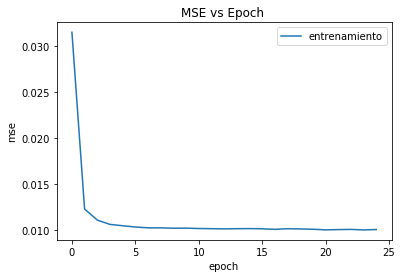

In [16]:
g_mseEpochs(history_e)

** Comentarios ** En la gráfica se observa claramente la convergencia del modelo, que ocurre en los primeros 5 epochs.

### f) Predicciones del modelo para los conjuntos de entrenamiento y prueba.  Datos desnormalizados para que el error pueda ser computado en la escala real.

In [17]:
def predict(p_trainX,p_trainY, p_testX, p_testY, p_batch_size, p_model):
    ##Para los datos de entrenamiento
    p_trainPredict = p_model.predict(p_trainX,batch_size=p_batch_size)
    p_trainPredict = scaler.inverse_transform(p_trainPredict)
    p_trainY_ = scaler.inverse_transform([p_trainY])
    
    ##Para los datos de prueba
    p_testPredict = p_model.predict(p_testX,batch_size=p_batch_size)
    p_testPredict = scaler.inverse_transform(p_testPredict)
    p_testY_ = scaler.inverse_transform([p_testY])
    
    return p_trainPredict, p_trainY_, p_testPredict, p_testY_

In [18]:
trainPredict,trainY_inv, testPredict,testY_inv =  predict(trainX,trainY, testX, testY, 1, model_e)

### g)  Cálculo de error RMSE (Root Mean Square Error) sobre el cojunto de entrenamiento y prueba 

In [19]:
def cal_RMSE(cal_trainY_, cal_trainPredict, cal_testY_, cal_testPredict):
    cal_trainScore = math.sqrt(mean_squared_error(cal_trainY_[0], cal_trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (cal_trainScore))
    cal_testScore = math.sqrt(mean_squared_error(cal_testY_[0], cal_testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (cal_testScore))
    return cal_trainScore, cal_testScore

In [20]:
trainScore, testScore = cal_RMSE(trainY_inv, trainPredict, testY_inv, testPredict)

Train Score: 2.73 RMSE
Test Score: 2.54 RMSE


** Comentarios ** Luego de que la red ha sido entrenada, el error para el conjunto de prueba es un 7% menor con respecto al error obtenido en los datos de entrenamiento.

### h) Gráfico de las predicciones de train y test, contrastada con la serie de tiempo original. Muestra de un extracto de la predicción para ver en mas detalle como es la predicción. Comentarios


In [21]:
def g_timeSeriesMulti(_series,
                      _labels,
                      _title,
                      _shifts,
                      min_x = None,
                      max_x = None,
                      original_offset = 0):
    """
    _series es la lista de series de tiempo a graficar
    _labels es la lista de etiquetas para cada serie en _series, respectivamente    
    _title es el titulo del grafico    
    
    Se asume que el largo de _series y _labels es el mismo
    y que este no es mayor que 6. En caso contrario se repetiran los colores
    """

    color = ['y','g','b','r','m','k']
    colorcycler = cycle(color)
    
    if not max_x:
        max_x = len(dataframe.values)
    
    if not min_x:
        min_x = 0
    
    _ = plt.figure(figsize=(15,7))
    _ = plt.plot(dataframe.values[original_offset + min_x: original_offset + max_x],next(colorcycler),alpha=0.4)
    plots = []
    i = 1
    for _serie, _shift in zip(_series, _shifts):
        # shift train predictions for plotting
        _serie_plot= np.empty_like(dataframe.values)        
        _serie_plot[:, :] = np.nan
        _serie_plot[_shift(lag), :] = _serie
        _ = plt.plot(_serie_plot[min_x:max_x], next(colorcycler))
        ax = plt.gca()
        new_xtick_labels = list(map(lambda xt: str(int(xt + min_x)), plt.xticks()[0]))
        ax.set_xticklabels(new_xtick_labels)
        plots.append(_serie_plot)
    
    _ = plt.title(_title)
    _ = plt.xlabel('Tiempo')
    _ = plt.ylabel('Grados')
    _ = plt.legend(_labels, loc='upper right')
    plt.show()
    return plots

In [22]:
def mk_shift_A(_trainPredict_):
    def shift_A(lag):
        return slice(lag,len(_trainPredict_)+lag)
    return shift_A

def mk_shift_A_lag(_trainPredict_, _lag):
    def shift_A_lag(lag):
        return slice(_lag,len(_trainPredict_)+_lag)
    return shift_A_lag
    
def mk_shift_B(_trainPredict_):
    def shift_B(lag): 
        return slice(len(_trainPredict_)+2*lag, None)
    return shift_B

def mk_shift_B_lag(_trainPredict_, _lag):
    def shift_B_lag(lag): 
        return slice(len(_trainPredict_)+2*_lag, None)
    return shift_B_lag

** Gráfico Serie Original, Datos de Entrenamiento y Pruebas para todos los datos**

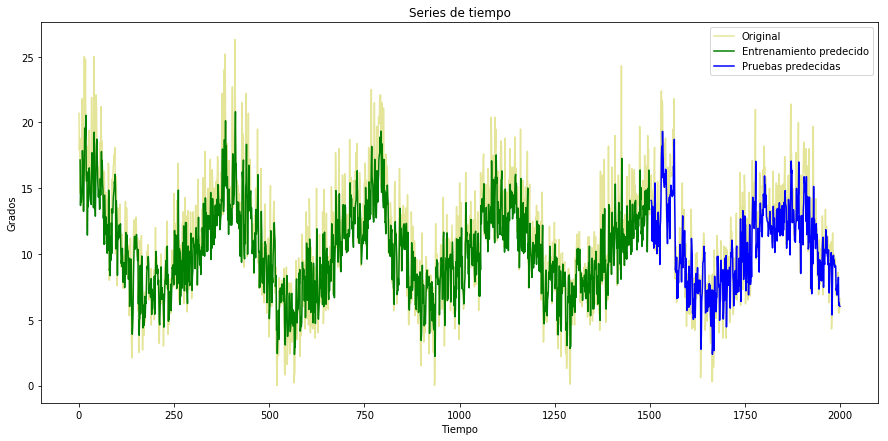

In [23]:
_ = g_timeSeriesMulti([trainPredict, testPredict],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo",
                  [mk_shift_A(trainPredict), mk_shift_B(trainPredict)]
                  )

** Comentario ** Se observa en el gráfico que los datos predecidos se aproximan a los datos reales, se encuentran por debajo de los datos reales. Las oscilaciones presentadas son muy similares.

** Extracto de gráfico **
Para los datos en el rango de 1450 a 1550

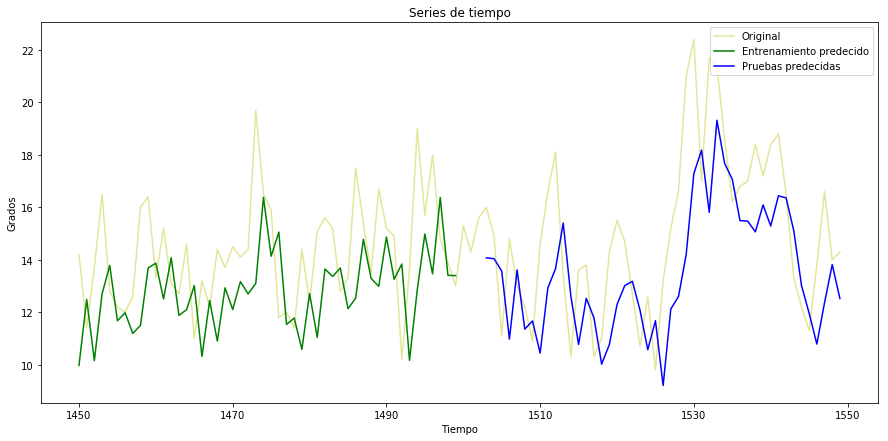

In [24]:
_ = g_timeSeriesMulti([trainPredict, testPredict],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo",
                  [mk_shift_A(trainPredict), mk_shift_B(trainPredict)],
                  min_x = 1450, max_x = 1550
                  )

** Comentarios: ** Se observa que tanto los datos de entrenamiento oscilan de igual forma que los datos reales, sin embargo se encuentran con un desfase y por debajo de estos. A continuación se gráfica en un rango más pequeño, considerando la predicción, (1510-1520) donde se observa con mayor detalle lo indicado anteriormente.

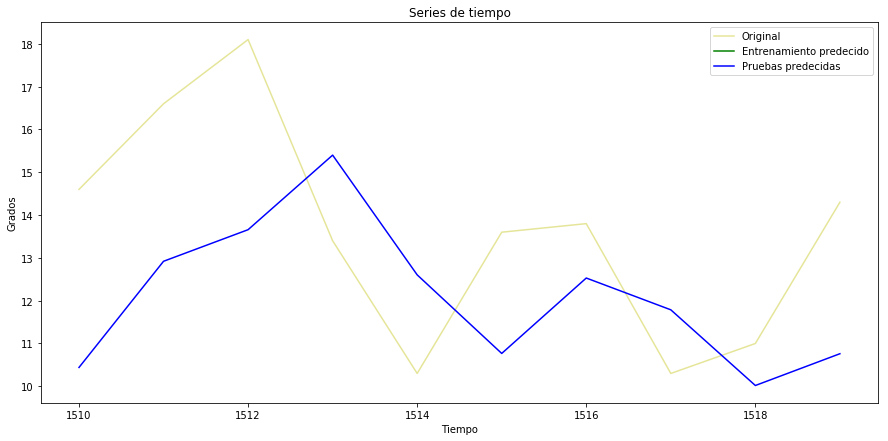

In [25]:
## Extracto gráfico 1510 a 1520

_ = g_timeSeriesMulti([trainPredict, testPredict],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo",
                  [mk_shift_A(trainPredict), mk_shift_B(trainPredict)],
                  min_x = 1510, max_x = 1520
                  )

### i) En lugar de aumentar el número de dimensiones como el paso e),  se entrena  la red con un *timestep* de 3 (con dimensión de entrada 1). 

** ¿Se produce una mejora del error de entrenamiento y pruebas? **
** ¿Los tiempos de computación son comparables? **
** Comentar brevemente sobre cual es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e). ** (Respuestas al final)

* Con la modalidad lag: (TotalDatos, 1,lag) - cantidad de instantes de tiempo que se agregan como dimensiones al input
* con la modalidad timestep: (TotalDatos, timesteps, 1) - instantes de tiempo que se considera como input

In [26]:
lag = 3
trainX_i, trainY_i, testX_i, testY_i = createData_TrainTest(lag, stream_train_scaled, stream_test_scaled)

In [27]:
##dando la forma deseada [samples,time step,features] modelo i)
def data_reshape(_trainX_, _testX_):
    _trainX_ = np.reshape(_trainX_, (_trainX_.shape[0], _trainX_.shape[1],1))  ## reshape de trainX
    _testX_  = np.reshape(_testX_,  (_testX_.shape[0] , _testX_.shape[1],1))   ## reshape de testX
    return _trainX_, _testX_

In [28]:
trainX_i, testX_i = data_reshape(trainX_i, testX_i)

In [29]:
print_format(trainX_i,trainY_i,testX_i, testY_i)
print_data(trainX_i, testX_i)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)
Data [[[0.7870723]
  [0.6806084]
  [0.7148289]]

 [[0.6806084]
  [0.7148289]
  [0.5551331]]

 [[0.7148289]
  [0.5551331]
  [0.6007605]]

 ...

 [[0.7224335]
  [0.5969582]
  [0.6844107]]

 [[0.5969582]
  [0.6844107]
  [0.5627377]]

 [[0.6844107]
  [0.5627377]
  [0.5285171]]]

Data [[[0.5817491 ]
  [0.54372627]
  [0.5931559 ]]

 [[0.54372627]
  [0.5931559 ]
  [0.60836506]]

 [[0.5931559 ]
  [0.60836506]
  [0.56653994]]

 ...

 [[0.32699624]
  [0.21673004]
  [0.20912549]]

 [[0.21673004]
  [0.20912549]
  [0.21673004]]

 [[0.20912549]
  [0.21673004]
  [0.21673004]]]



In [30]:
lag = 3
history_i = []
model_i, history_i, time_i = create_model(4, 1,trainX_i,trainY_i, 25, 1, lag)

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0218 - acc: 0.0013
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0120 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0118 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0113 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0110 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0108 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 11/25
1497/14

** Gráfico MSE vs Epochs para Modelo i) **

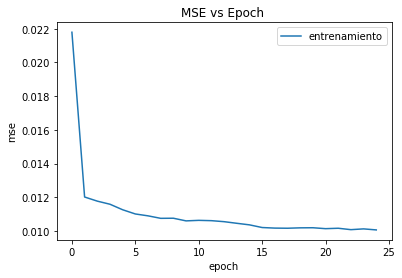

In [31]:
g_mseEpochs(history_i)

** Comentarios ** Se observa que la convergencia se produce luego de los 15 primeros epochs. A diferencia del modelo e) que se produjo en los primeros 5 epochs.

** Predicciones del modelo **

In [32]:
batch_size = 1
trainPredict_i,trainY_i_inv, testPredict_i,testY_i_inv =  predict(trainX_i,trainY_i, testX_i, testY_i, 1, model_i)

** Cálculo del error RMSE **

In [33]:
##Cálculo de root mean square error
trainScore_i, testScore_i = cal_RMSE(trainY_i_inv, trainPredict_i, testY_i_inv, testPredict_i)

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE


** Comentarios:** El error del conjunto de prueba es un 7,6% menor al error del conjunto de entrenamiento. Esto se puede explicar por que la red ya se encuentra entrenada.

** Gráfico de predicción **

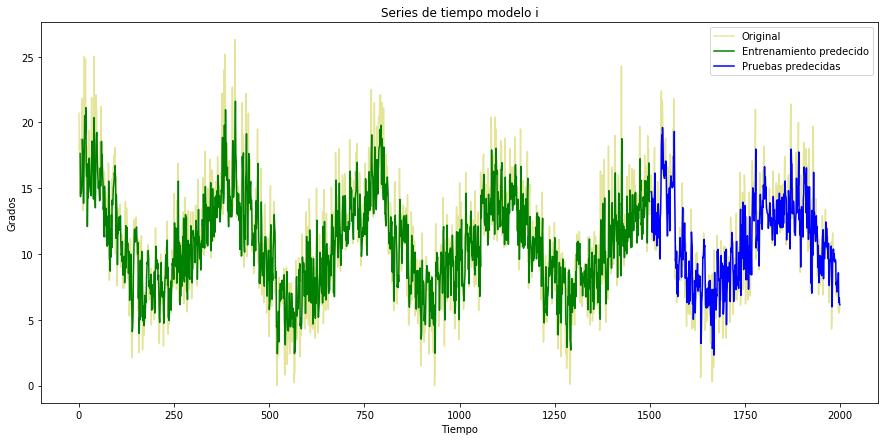

In [34]:
_ = g_timeSeriesMulti([trainPredict_i, testPredict_i],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo modelo i",
                  [mk_shift_A(trainPredict_i), mk_shift_B(trainPredict_i)]
                  )

** Gráfico que compara predicción modelo e) vs i) **

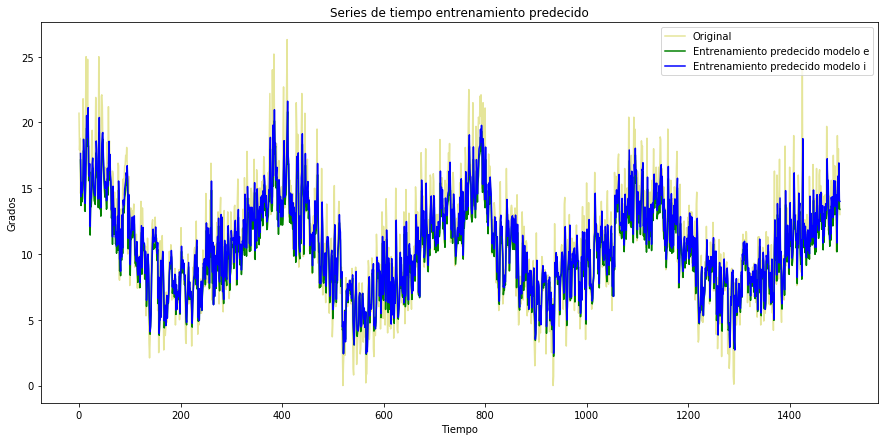

In [35]:
_ = g_timeSeriesMulti([trainPredict, trainPredict_i],
                  ["Original", "Entrenamiento predecido modelo e", "Entrenamiento predecido modelo i"],
                  "Series de tiempo entrenamiento predecido",
                  [mk_shift_A(trainPredict), mk_shift_A(trainPredict_i)],
                  max_x = 1500)

** Comentarios: ** En el gráfico se observa como los datos del modelo i) se aproximan más a los datos originales. Para corroborar esto es que a continuación se presenta un gráfico en el rango de 1450 a 1500.

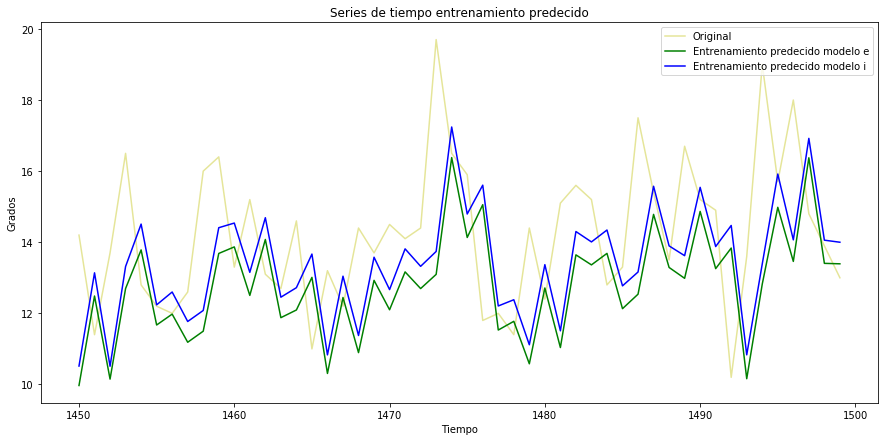

In [36]:
_ = g_timeSeriesMulti([trainPredict, trainPredict_i],
                  ["Original", "Entrenamiento predecido modelo e", "Entrenamiento predecido modelo i"],
                  "Series de tiempo entrenamiento predecido",
                  [mk_shift_A(trainPredict), mk_shift_A(trainPredict_i)],
                  min_x = 1450, max_x = 1500)

** Comentarios:** los datos del modelo i) se aproximan más a los datos originales, que los datos del modelo e). Ambos modelos oscilan de igual forma y con el mismo desfase con respecto a los datos originales.

In [37]:
def boxplot_data(data1, data2, title, valueX1, valueX2):
    data= [data1[0],data2[0]]
    _ = plt.figure(figsize=(10,5))
    _ = plt.title(title)
    _ = plt.boxplot(data)
    _ = plt.xticks([1,2],(valueX1,valueX2))
    _ = plt.show()

In [38]:
## Modelo e)
trainPredictDF = pd.DataFrame(trainPredict)
testPredictDF =  pd.DataFrame(testPredict)

## Modelo i)
trainPredict_i_DF = pd.DataFrame(trainPredict_i)
testPredict_i_DF =  pd.DataFrame(testPredict_i)

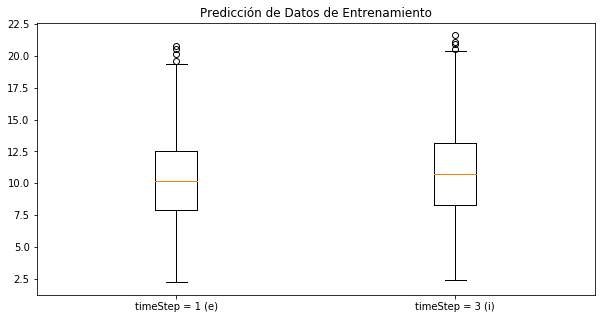

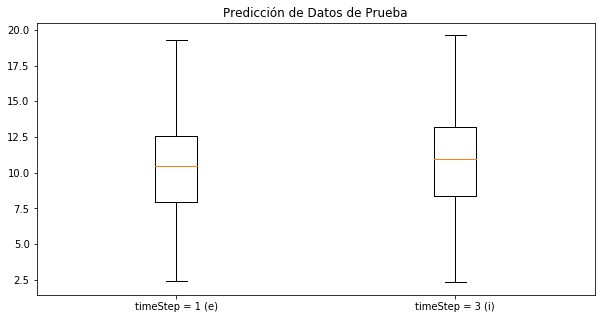

In [39]:
## Graficos de caja para los datos predecidos 
boxplot_data(trainPredictDF, trainPredict_i_DF, "Predicción de Datos de Entrenamiento", 
             "timeStep = 1 (e)","timeStep = 3 (i)")
boxplot_data(testPredictDF, testPredict_i_DF, "Predicción de Datos de Prueba",
             "timeStep = 1 (e)","timeStep = 3 (i)")

In [40]:
## Impresión de tiempos

print("Modelo e %s" % str(time_e))
print("Modelo i %s" % str(time_i))

Modelo e 335.6558701992035
Modelo i 308.7288296222687


** Comparandos resultados **

** ¿ Se produce una mejora del error de entrenamiento y prueba? **

Sí, con un timeStep mayor se reduce RMSE para los datos de entrenamiento y prueba.

Para ambos modelos el error de prueba misminuye aprox. un 7% con respecto al error del conjunto de entrenamiento.

** ¿Los tiempos de computación son comparables? **

El modelo e) se demora un 9% más en entrenar que el modelo i), 

** Forma correcta para aprvovechar la información a través del tiempo **

De acuerdo a los resultados, la forma correcta corresponde a la realizada en este paso (memoria/timestep = 3 -  instantes de tiempo que se considera como input), utiliza menos tiempo en el entrenamiento y se obtienen mejores resultados para RMSE.

Al considerar más instantes de tiempo, se tiene mayor información para poder predecir.

** Resumen de los datos obtenidos: **
* con timestep = 1 (e):
  * Tiempo de entrenamiento: 335.6558701992035 seg.
  * Train Score: 2.73 RMSE
  * Test Score: 2.54 RMSE
  * Converge en los primers 5 epochs.
  
* con timestep = 3 (i): 
  * Tiempo de entrenamiento: 308.7288296222687 seg.
  * Train Score: 2.63 RMSE
  * Test Score: 2.43 RMSE
  * Converge luego de los 15 epochs.
  
* En los diagramas de cajas, se observa que para el caso de timeStep = 3, los datos se encuentran más centrados que con timeStep = 1
* En los gráficos se series de tiempo, para ambos modelos se aproximan a los datos predecidos, pero se encuentran con desface y bajo los datos reales. Los datos del modelo i) se asemejan más a los datos reales.


### j) Determine el parámetro del número de bloques para la LSTM de la pregunta e) o i), lo que le parezca mas sensato en base a lo analizado en la pregunta anterior. 
### Utilice 5-fold *cross validation*, o bien, en su defecto, los datos restante no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante) como conjunto fijo de validación. Comente.

** Se utiliza el modelo de la pregunta i) y 5-fold cross validation **

In [41]:
lag = 3
trainX, trainY, testX, testY = createData_TrainTest(lag, stream_train_scaled, stream_test_scaled)
trainX, testX = data_reshape(trainX, testX) ## De acuerdo al modelo i)
print_format(trainX, trainY, testX, testY)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)


In [42]:
kfold = cross_validation.KFold(len(trainX), 5) #ultimo parametro es 5

trainPredict_kfold_all = []
testPredict_kfold_all = []
trainScore_kfold_all = []
testScore_kfold_all = []
history_data_loss_all = []
history_data_accu_all = []
cvscores_all=[]
nb = range(4, 13, 2)
chosen_dim = 1  ## de acuerdo a respuesta i)
for n in nb:
    print("\n n: %d" % n)
    cvscores = []
    history_data_loss = []
    history_data_accu = []
    trainScore_kfold = []
    testScore_kfold = []
    trainPredict_kfold = []
    testPredict_kfold = []
    for train_idx, evaluate_idx in kfold:
        print("\ntrain index: %s" % len(train_idx))       
        print("evaluate index: %s" % len(evaluate_idx))
        
        #crear modelo y entrenar
        model_j, hist_j, _ =create_model(n, chosen_dim,trainX,trainY, 25, 1, lag)
        history_data_loss.append(hist_j[0].history['loss'])
        
        #evaluar modelo
        scores = model_j.evaluate(trainX[evaluate_idx], trainY[evaluate_idx], verbose=0)  
        scores
        print("\n%s: %.4f%%\n" % (model_j.metrics_names[0], scores[0]*100))
        cvscores.append(scores[0] * 100)
        
        ## Predecir
        trainPredict_j, trainY_j, testPredict_j, testY_j = predict(trainX,trainY, testX, testY,1, model_j)
        
        trainPredict_kfold.append(trainPredict_j)
        testPredict_kfold.append(testPredict_j)
       
        ##Cálculo de root mean square error
        trainScore_j,testScore_j = cal_RMSE(trainY_j,trainPredict_j, testY_j,testPredict_j)
        trainScore_kfold.append(trainScore_j)
        testScore_kfold.append(testScore_j)
        
    print("%.4f%% (+/- %.4f%%)" % (np.mean(cvscores), np.std(cvscores)))
    history_data_loss_all.append(history_data_loss)
    cvscores_all.append(cvscores)    
    trainScore_kfold_all.append(trainScore_kfold)
    testScore_kfold_all.append(testScore_kfold)
    trainPredict_kfold_all.append(trainPredict_kfold)
    testPredict_kfold_all.append(testPredict_kfold)


 n: 4

train index: 1197
evaluate index: 300


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0165 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0121 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0117 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0114 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0113 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0110 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0108 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 11/25
1497/14

[0.009533321789155403, 0.0]


loss: 0.9533%

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE

train index: 1197
evaluate index: 300
Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0188 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0119 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0114 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0112 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25
1497/1

[0.01101290265719096, 0.006666666666666667]


loss: 1.1013%

Train Score: 2.65 RMSE
Test Score: 2.45 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0192 - acc: 0.0013
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0118 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0113 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 32s 22ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 35s 24ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 33s 22ms/step - loss: 0.0107 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 32s 21ms/step - loss: 0.0105 - acc: 0.0020
Epoch 10/25
14

[0.009784208803770933, 0.0]


loss: 0.9784%

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 39s 26ms/step - loss: 0.0241 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 35s 24ms/step - loss: 0.0120 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 37s 24ms/step - loss: 0.0116 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 37s 25ms/step - loss: 0.0113 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 33s 22ms/step - loss: 0.0110 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 32s 22ms/step - loss: 0.0109 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 33s 22ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 36s 24ms/step - loss: 0.0106 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 34s 23ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/

[0.00928751766264289, 0.0033444816053511705]


loss: 0.9288%

Train Score: 2.62 RMSE
Test Score: 2.41 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 40s 27ms/step - loss: 0.0228 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 36s 24ms/step - loss: 0.0127 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 39s 26ms/step - loss: 0.0124 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 38s 25ms/step - loss: 0.0121 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 35s 23ms/step - loss: 0.0122 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 35s 23ms/step - loss: 0.0117 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 33s 22ms/step - loss: 0.0115 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 37s 25ms/step - loss: 0.0114 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 35s 24ms/step - loss: 0.0112 - acc: 0.0020
Epoch 10/

[0.010271824924368723, 0.0]


loss: 1.0272%

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE
0.9978% (+/- 0.0611%)

 n: 6

train index: 1197
evaluate index: 300


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(6, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 37s 25ms/step - loss: 0.0146 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 34s 23ms/step - loss: 0.0116 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 38s 26ms/step - loss: 0.0114 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 23s 15ms/step - loss: 0.0112 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0110 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 17s 11ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 17s 12ms/step - loss: 0.0107 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 17s 11ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0104 - acc: 0.0020
Epoch 11/2

[0.010106811641405027, 0.0]


loss: 1.0107%

Train Score: 2.71 RMSE
Test Score: 2.52 RMSE

train index: 1197
evaluate index: 300
Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0278 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0122 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0117 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0114 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25
1497/1

[0.010926556202272574, 0.006666666666666667]


loss: 1.0927%

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 32s 21ms/step - loss: 0.0201 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0123 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0119 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 26s 17ms/step - loss: 0.0117 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0112 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0104 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0103 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0103 - acc: 0.0020
Epoch 10/

[0.009866077608637586, 0.0]


loss: 0.9866%

Train Score: 2.64 RMSE
Test Score: 2.44 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0269 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 14s 10ms/step - loss: 0.0123 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 14s 10ms/step - loss: 0.0118 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 15s 10ms/step - loss: 0.0117 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0114 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0107 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25


[0.009295593571061125, 0.0033444816053511705]


loss: 0.9296%

Train Score: 2.62 RMSE
Test Score: 2.41 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 31s 21ms/step - loss: 0.0273 - acc: 0.0013
Epoch 2/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0120 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0114 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0111 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 29s 20ms/step - loss: 0.0110 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 29s 20ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/

[0.010305495655481832, 0.0]


loss: 1.0305%

Train Score: 2.69 RMSE
Test Score: 2.50 RMSE
1.0100% (+/- 0.0534%)

 n: 8

train index: 1197
evaluate index: 300


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(8, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0213 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0123 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0119 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0115 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 19s 13ms/step - loss: 0.0113 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0109 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 26s 17ms/step - loss: 0.0108 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0104 - acc: 0.0020
Epoch 11/25


[0.009556962251663208, 0.0]


loss: 0.9557%

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE

train index: 1197
evaluate index: 300
Epoch 1/25
1497/1497 [==============================] - 32s 21ms/step - loss: 0.0185 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0122 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0118 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0116 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0113 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 26s 17ms/step - loss: 0.0109 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0105 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/

[0.010997867844998836, 0.006666666666666667]


loss: 1.0998%

Train Score: 2.64 RMSE
Test Score: 2.44 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0218 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0124 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0120 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0112 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0108 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0105 - acc: 0.0020
Epoch 10/25
1

[0.009912730596436306, 0.0]


loss: 0.9913%

Train Score: 2.65 RMSE
Test Score: 2.46 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 34s 23ms/step - loss: 0.0191 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0122 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 26s 18ms/step - loss: 0.0118 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0113 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 28s 18ms/step - loss: 0.0108 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0106 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 30s 20ms/step - loss: 0.0103 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0103 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/

[0.00952629662776073, 0.0033444816053511705]


loss: 0.9526%

Train Score: 2.64 RMSE
Test Score: 2.44 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0243 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0124 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0119 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0114 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 10/25
1497/1

[0.010101545278144919, 0.0]


loss: 1.0102%

Train Score: 2.62 RMSE
Test Score: 2.41 RMSE
1.0019% (+/- 0.0535%)

 n: 10

train index: 1197
evaluate index: 300


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0129 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 11/25
1497/14

[0.009593276561548313, 0.0]


loss: 0.9593%

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE

train index: 1197
evaluate index: 300
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0226 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0125 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0120 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0115 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0112 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/25
1497/1

[0.010929321087896824, 0.006666666666666667]


loss: 1.0929%

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0201 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0120 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0115 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/25
1497/1

[0.009744073622501813, 0.0]


loss: 0.9744%

Train Score: 2.61 RMSE
Test Score: 2.41 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0202 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0122 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0112 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 10/25
1497/1

[0.009332307578565983, 0.0033444816053511705]


loss: 0.9332%

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0230 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0124 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0118 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0114 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0110 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0108 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 10/25
1497/1

[0.010377812604217426, 0.0]


loss: 1.0378%

Train Score: 2.64 RMSE
Test Score: 2.43 RMSE
0.9995% (+/- 0.0580%)

 n: 12

train index: 1197
evaluate index: 300


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0198 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0124 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0117 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0112 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0107 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 11/25
1497/14

[0.009522255932291349, 0.0]


loss: 0.9522%

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE

train index: 1197
evaluate index: 300
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0153 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0120 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0111 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0108 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 10/25
1497/1

[0.010732872237761815, 0.006666666666666667]


loss: 1.0733%

Train Score: 2.61 RMSE
Test Score: 2.41 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0206 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0124 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0116 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0113 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/25
1497/1

[0.010004653850800816, 0.0]


loss: 1.0005%

Train Score: 2.64 RMSE
Test Score: 2.44 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 10ms/step - loss: 0.0128 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0115 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0106 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0104 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/25
1497/

[0.009306144781479219, 0.0033444816053511705]


loss: 0.9306%

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE

train index: 1198
evaluate index: 299
Epoch 1/25
1497/1497 [==============================] - 14s 10ms/step - loss: 0.0177 - acc: 0.0020
Epoch 2/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0118 - acc: 0.0020
Epoch 3/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0115 - acc: 0.0020
Epoch 4/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0109 - acc: 0.0020
Epoch 5/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0104 - acc: 0.0020
Epoch 6/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0105 - acc: 0.0020
Epoch 7/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 8/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0103 - acc: 0.0020
Epoch 9/25
1497/1497 [==============================] - 13s 8ms/step - loss: 0.0102 - acc: 0.0020
Epoch 10/25
1497/

[0.01008534128699813, 0.0]


loss: 1.0085%

Train Score: 2.61 RMSE
Test Score: 2.42 RMSE
0.9930% (+/- 0.0496%)


** Comentarios **
 
Para el análisis de resultados, se realizan distintos tipos de gráficos, los que se presentan a continuación junto con análisis de resultados. 

** Gráfico par ver Loss vs MSE de cada valor de n **

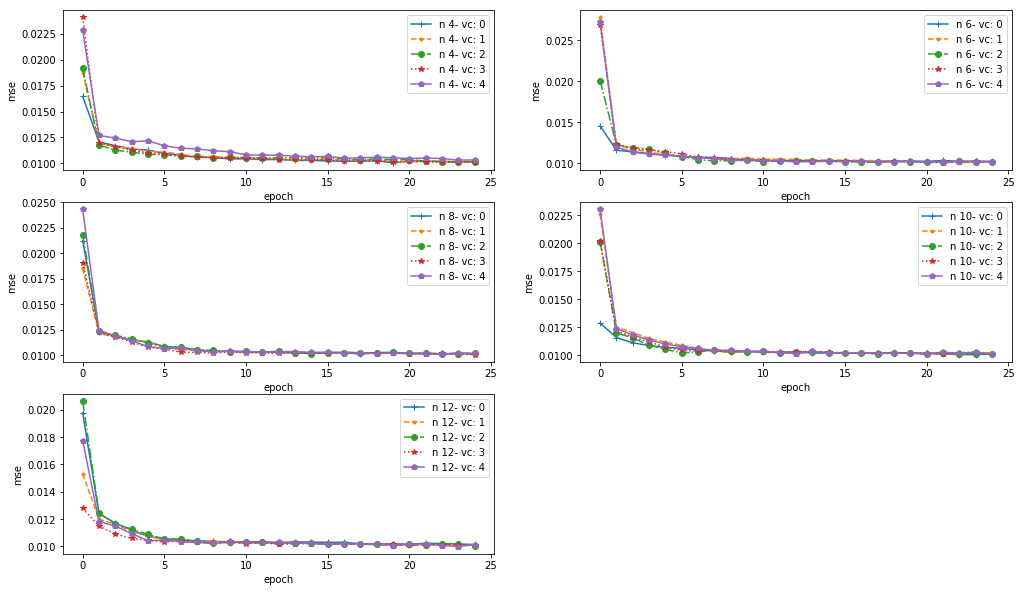

In [43]:
_ = plt.close('all')
_ = plt.figure(figsize=(17,10))

for i in range(1,6):
    _ = plt.subplot(3,2,i)
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    m = ['+','.','o','*','p','s','x','D','h','^']
    mcycler = cycle(m)

    for j in range(0,5):
        _ = plt.plot(history_data_loss_all[i-1][j], marker = next(mcycler),
                     linestyle = next(linecycler),label = "n "+ str(i+i+2) +"- vc: "+str(j))
        _ = plt.xlabel('epoch')
        _ = plt.ylabel('mse')
        _ = plt.legend(loc='upper right')
plt.show()

** Comentarios: ** Se observa en los gráficos que a medida que aumenta el valor de n, los valores de MSE comienzan de un valor mucho más pequeño.

En todos los gráficos se observa convergencia, en los primeros 5 epochs.

** Gráfico para ver el valor de pérdida para cada modelo **

In [44]:
def loss_gLinea(data,n_inf, n_sup, n, n1, textx, texty, title, val, textLabel):
    """
    data: datos a graficar
    n_inf: limite inferior de eje x
    n_suf: límite superior de eje x
    n,n1: valor para describir el label
    val: si se utiliza ejex descrito, con =1
    """
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    m = ['+','.','o','*','p','s','x','D','h','^']
    mcycler = cycle(m)
    _ = plt.close('all')
    _ = plt.figure(figsize=(15,7))
    for i in range(n_inf,n_sup):
        _ = plt.plot(data[i], marker = next(mcycler),
                     linestyle = next(linecycler),label = textLabel+ str(n*i+n_sup-1+n1))
        _ = plt.xlabel(textx)
        _ = plt.ylabel(texty)
        _ = plt.title(title)
        _ = plt.legend(loc='upper right')
        if val==1:
            _ = plt.xticks(range(n_inf,n_sup),("1","2","3","4","5"))
    plt.show()

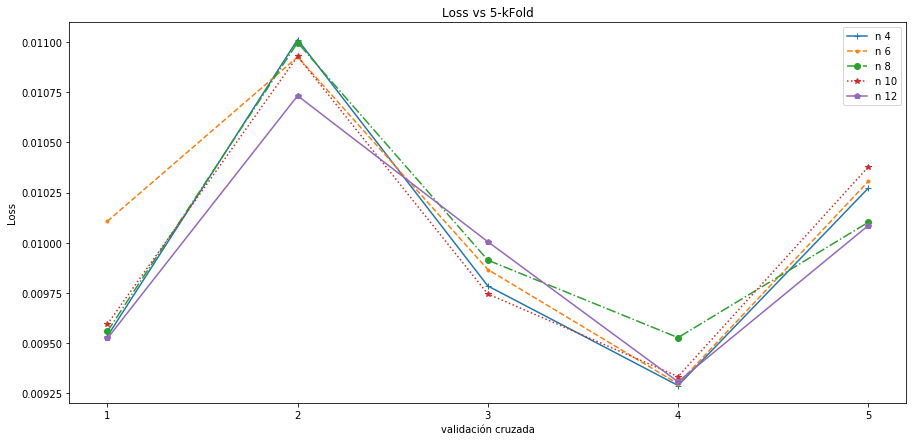

In [45]:
loss_gLinea(np.divide(cvscores_all,100),0,5, 2,0,"validación cruzada", "Loss", "Loss vs 5-kFold",1,"n ")

** Comentarios:**
En el gráfico se presenta el valor de pérdida al  evaluar cada modelo para cada iteración de k-fold (k=5). 
Apesar de que para todos los valores de n (nodos en LSTM), se obtienen resultados bastante similares,  en cuando a valores y comportamiento, los menores valores se obtienen en la cuarta validación. Esto es por los datos que se encuentran para esa validación y test.

** Gráfico de valores RMSE para cada iteración de k-fold, para datos de entrenamiento y prueba ** (comentarios más abajo)

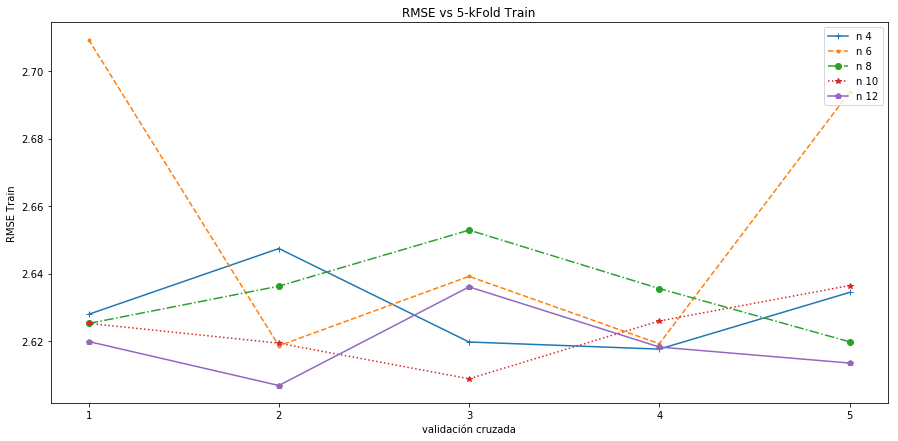

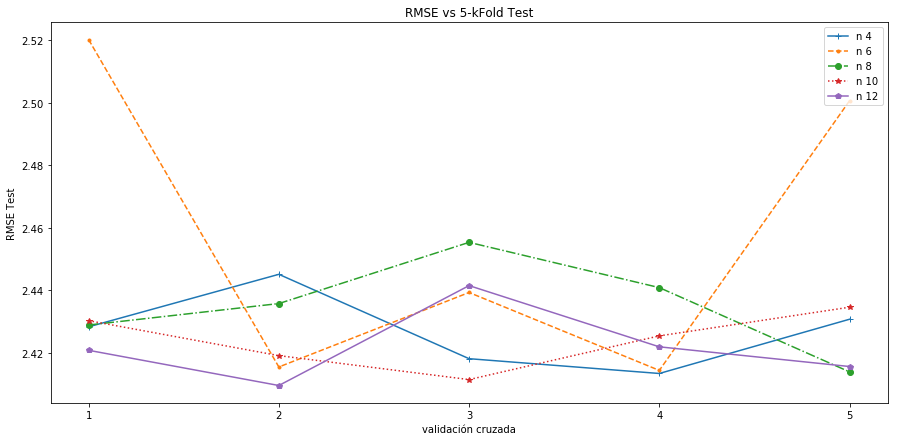

In [46]:
## Para Train
loss_gLinea(trainScore_kfold_all,0,5, 2,0,"validación cruzada", "RMSE Train", "RMSE vs 5-kFold Train",1,"n ")
## Para Test
loss_gLinea(testScore_kfold_all,0,5, 2,0,"validación cruzada", "RMSE Test", "RMSE vs 5-kFold Test",1,"n ")


In [47]:
## Obteniendo en que iteración se obtuvo el menor valor de RMSE para train  y test

# Min RMSE train -- buscar  la predicción en esa iteración
print("Menor valor RMSE %s de Train" % str(np.amin(trainScore_kfold_all)))
min_tr=np.argmin(trainScore_kfold_all)
min_n_train, min_pred_train=divmod(min_tr, 5) ## 5 kflod

# Min RMSE test -- buscar  la predicción en esa iteración
print("Menor valor RMSE %s de Test\n" % str(np.amin(testScore_kfold_all)))
min_te=np.argmin(trainScore_kfold_all)
min_n_test, min_pred_test=divmod(min_te, 5) ## 5 kflod

print("El menor valor de RMSE en predicción para Train esta en n=%s e iteración de kfold %s" % ((min_n_train+1)*2+2,min_pred_train+1))
print("El menor valor de RMSE en predicción para Test esta en n=%s e iteración de kfold %s" % ((min_n_test+1)*2+2,min_pred_test+1))

## Para gráficar toda la serie, se elige el menor RMSE de test
min_n = min_n_test
min_p = min_pred_test

## De acuerdo a gráfico se selecciona los siguientes valores para RMSE (en caso que sean de iteraciones distintas 
##se selecciona iteracion de test con el objetivo de trabajar con la misma serie) 

Menor valor RMSE 2.6068222180659406 de Train
Menor valor RMSE 2.4095580057960575 de Test

El menor valor de RMSE en predicción para Train esta en n=12 e iteración de kfold 2
El menor valor de RMSE en predicción para Test esta en n=12 e iteración de kfold 2


** Comentarios** 

De acuerdo a los valores obtenidos en RMSE, a lo largo de los distintas interaciones con n fijo, se observa que con n=12 se obtienen los mejores resultados para RMSE tanto para los datos de entrenamiento como prueba, es decir los valores más pequeños para RMSE. Esto es considerando las distintas iteraciones en k-fold. El menor valor se encuentra en la segunda iteración.

Para los  valores de n= (4, 6, 8, 10, 12), el comportamiento es bastante inestable, sin embargo con n=8 y  n=12 los valores de RMSE tieneden a ir dismiuyendo (a pesar de que se menatienen oscilando).

De acuerdo a esto, es que se selecciona los valores obtenidos en la predicción para n=12, para seguir analizando resultados, en específico los valores obtenidos en la segunda validación cruzada, que es donde se obtiene el valor mas pequeño de RMSE.

** Gráfico de Predicción **

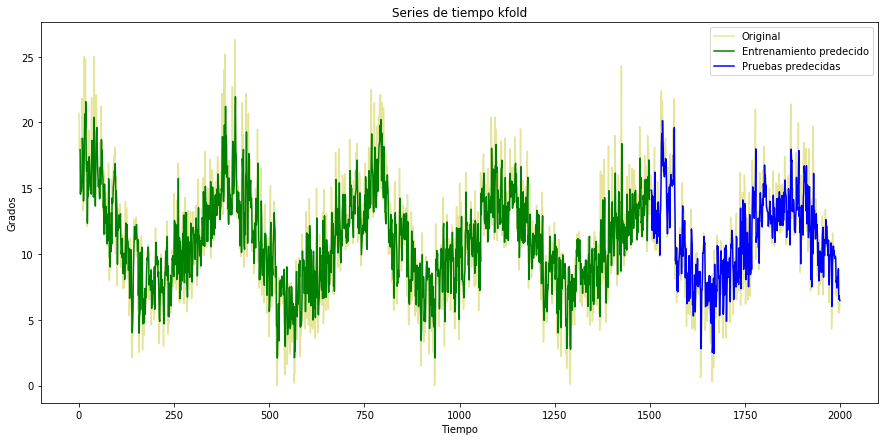

In [48]:
_ = g_timeSeriesMulti([trainPredict_kfold_all[min_n][min_p], testPredict_kfold_all[min_n][min_p]],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo kfold",
                  [mk_shift_A(trainPredict_kfold_all[min_n][min_p]), mk_shift_B(trainPredict_kfold_all[min_n][min_p])]
                  )

** Comentarios ** En el gráfico se presentan los datos para n=12 e iteración kfold=2. Se observa que los datos se encuentran mucho mas centrados con respecto a los datos originales. Que además se corrobora con el valor de RMSE obtenido que es menor que modelos anteriores.

A conitnuación se presenta un extracto de gráfico, para ver en mas detalle el comportamiento de los datos predecidos. Comparando con el  Modelo i).

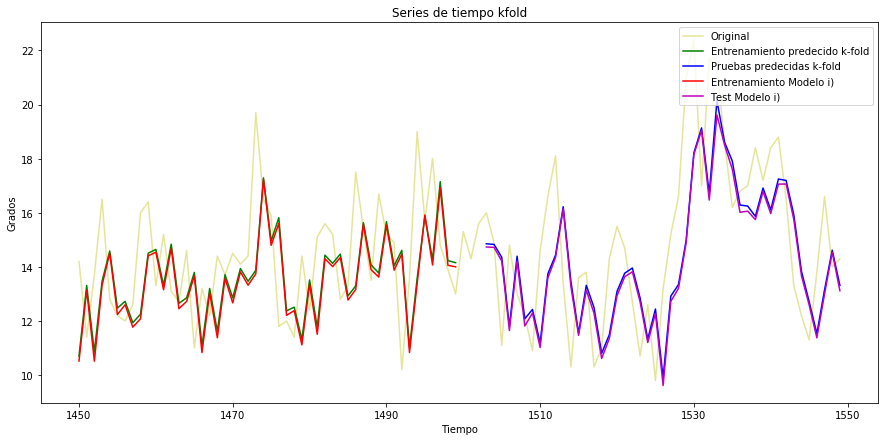

In [49]:
_ = g_timeSeriesMulti([trainPredict_kfold_all[min_n][min_p], testPredict_kfold_all[min_n][min_p], trainPredict_i, testPredict_i],
                  ["Original", "Entrenamiento predecido k-fold", "Pruebas predecidas k-fold", "Entrenamiento Modelo i)", "Test Modelo i)"],
                  "Series de tiempo kfold",
                  [mk_shift_A(trainPredict_kfold_all[min_n][min_p]), mk_shift_B(trainPredict_kfold_all[min_n][min_p]),
                  mk_shift_A(trainPredict_i), mk_shift_B(trainPredict_i)],
                  min_x = 1450, max_x = 1550
                  )

** Comentarios **  Como se observa en los gráficos, el valor de los datos de predicción y test están por debajo de los datos reales, sin embargo el desfase es muy menor, con respecto a las gráficas de modelo i). 

La mejora se puede deber a que se fue aumentado el número nodos/neuronas en las capas ocultas dentro de la celda LSTM, teniendo más parámetros para entrenar.

A continuación se presentan los valores de RMSE para modelo i) y el menor valor obtenido con k-fold.

In [50]:
print("RMSE Train Modelo i)", trainScore_i)
print("RMSE Train k-Fold)  ", np.amin(trainScore_kfold_all))

print("\nRMSE Test Modelo i) ", testScore_i)
print("RMSE Train k-Fold)  ", np.amin(testScore_kfold_all))

RMSE Train Modelo i) 2.6323652809021625
RMSE Train k-Fold)   2.6068222180659406

RMSE Test Modelo i)  2.429142858503236
RMSE Train k-Fold)   2.4095580057960575


** Extracto de Gráfico para datos de entrenamiento ** Con el objetivo de ver en más detalle lo indicado anteriormente.

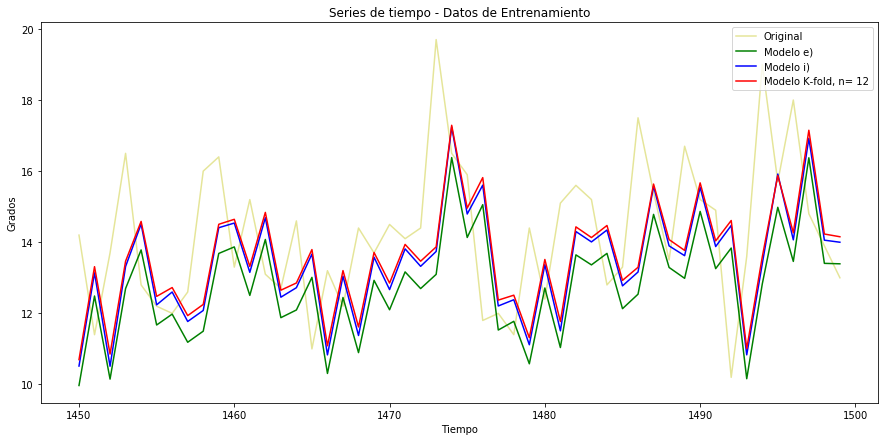

In [51]:
_ = g_timeSeriesMulti([trainPredict, trainPredict_i, trainPredict_kfold_all[min_n][min_p]],
                  ["Original", "Modelo e)", "Modelo i)", "Modelo K-fold, n= "+str((min_n+1)*2+2)],
                  "Series de tiempo - Datos de Entrenamiento",
                  [mk_shift_A(trainPredict), mk_shift_A(trainPredict_i), mk_shift_A(trainPredict_kfold_all[min_n][min_p])],
                  min_x = 1450, max_x = 1500)

** Comentarios ** En los gráficos se observa, que los datos con n=12(nodos en LSTM), en entrenamiento, se asemenjan mucho más  a los datos originales, que los resultados obtenidos en la pregunta e) e i), a pesar de que se mantiene el desfase. A continuación se presenta un gráfico con todas las predicciones (de acuerdo a k-fold) para n=12 para los datos de entrenamiento.

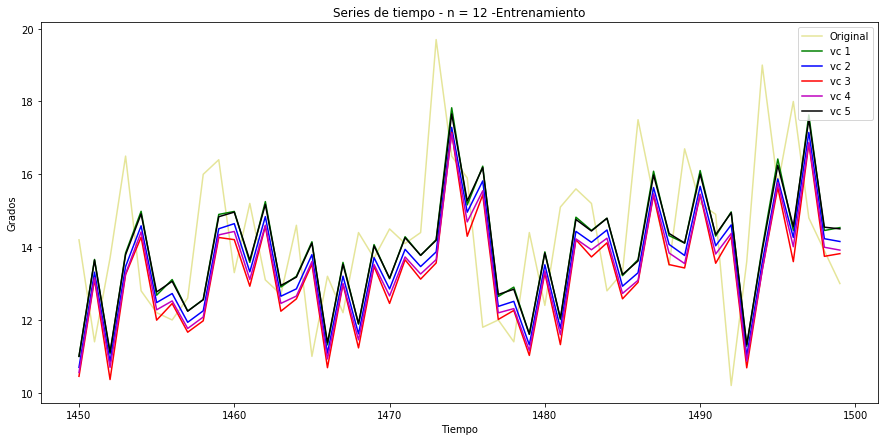

In [52]:
_ = g_timeSeriesMulti([trainPredict_kfold_all[min_n][0], trainPredict_kfold_all[min_n][1], trainPredict_kfold_all[min_n][2], 
                       trainPredict_kfold_all[min_n][3], trainPredict_kfold_all[min_n][4]],
                  ["Original", "vc 1", "vc 2", "vc 3","vc 4", "vc 5"],
                  "Series de tiempo - n = " + str((min_n+1)*2+2)+" -Entrenamiento",
                  [mk_shift_A(trainPredict_kfold_all[min_n][0]), mk_shift_A(trainPredict_kfold_all[min_n][0]), 
                   mk_shift_A(trainPredict_kfold_all[min_n][0]), mk_shift_A(trainPredict_kfold_all[min_n][0]),
                  mk_shift_A(trainPredict_kfold_all[min_n][0])],
                  min_x = 1450, max_x = 1500)

** Comentarios: ** Se observa graficamente que con kfold=1 y 5 se obtienen los valores más cercanos a los datos originales, con n=12.

A modo general, se conluye que sí se puede aumentar la cantidad de nodos en la LSTM, obteniendo una pequeña mejora en los resultados.

### K) Comparando el desempeño de la red LSTM variando el lag de 1  a  4. Comentar que resulta mejor, tener más información para predecir o esto satura la predicción por el efecto del gradiente descendiente.

In [53]:
## Entrenar
## Predecir
## Calcula valor de RMSE


history_lag = []
history_lag_all = []
time_all = []
trainScore_lag_all = []
testScore_lag_all = []
trainPredict_lag_all = []
testPredict_lag_all = []
lag_value = [1,2,3,4]
for lag_v in lag_value:   
    ## define el tamaño del lag
    print("Lag %s "  % (lag_v))   
    trainX_k, trainY_k, testX_k, testY_k = createData_TrainTest(lag_v, stream_train_scaled, stream_test_scaled)
    trainX_k, testX_k = data_reshape(trainX_k, testX_k) ## De acuerdo al modelo i)
    print_format(trainX_k, trainY_k, testX_k, testY_k)
    
    ##Crea modelo y entrena
    model_k, hist_k, time_k =create_model(4, 1,trainX_k,trainY_k, 25, 1, lag_v)
    history_lag_all.append(hist_k[0].history['loss'])
    time_all.append(time_k)

    ## Predecir
    trainPredict_k, trainY_inv_k, testPredict_k, testY_inv_k = predict(trainX_k,trainY_k, testX_k, testY_k,1, model_k )
    trainPredict_lag_all.append(trainPredict_k)
    testPredict_lag_all.append(testPredict_k)
    
    ##Cálculo de root mean square error
    trainScore_k,testScore_k = cal_RMSE(trainY_inv_k,trainPredict_k, testY_inv_k,testPredict_k)  
    trainScore_lag_all.append(trainScore_k)
    testScore_lag_all.append(testScore_k)

Lag 1 
TrainX (1499, 1, 1)
TrainY (1499,)
TestX (499, 1, 1)
TestY (499,)


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1499/1499 [==============================] - 11s 8ms/step - loss: 0.0296 - acc: 0.0020
Epoch 2/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0121 - acc: 0.0020
Epoch 3/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0108 - acc: 0.0020
Epoch 4/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0106 - acc: 0.0020
Epoch 5/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0107 - acc: 0.0020
Epoch 6/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0107 - acc: 0.0020
Epoch 7/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0106 - acc: 0.0020
Epoch 8/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0106 - acc: 0.0020
Epoch 9/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0106 - acc: 0.0020
Epoch 10/25
1499/1499 [==============================] - 10s 6ms/step - loss: 0.0106 - acc: 0.0020
Epoch 11/25
1499/14

** Comentarios:** Para el análisis de resultados, se presentan los siguientes gráficos:

* Tiempo para cada lag
* Gráfico de barras comparando valore de RMSE para test y predict
* Diagrama de caja para trainPredict y testPredict
* Loss para cada lag (gráfico de líneas)
* Gráficos de serie de tiempo

Luego de todos los gráficos y resultados, se presentan análisis y comnetarios.

In [54]:
def bar_lag(values1,textX, textY, title):
    lag_values= ("lag1", "lag2", "lag3", "lag4")
    posicion_x = np.arange(len(lag_values))
    _ = plt.bar(lag_values, values1, align = "center")
    _ = plt.xticks(posicion_x, lag_values)
    _ = plt.xlabel(textX)
    _ = plt.ylabel(textY)
    _ = plt.title(title)

In [55]:
def twobar_lag(value1,value2,text1,text2): ##value1: train, value2: Test
    # data to plot
    n_groups = 4  
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8
    rects1 = plt.bar(index, value1, bar_width,
                 alpha=opacity,
                 color='b',
                 label=text1)
    rects2 = plt.bar(index + bar_width, value2, bar_width,
                 alpha=opacity,
                 color='g',
                 label=text2)
    plt.xlabel('Lag')
    plt.ylabel('RMSE')
    plt.title('RMSE para cada lag')
    plt.xticks(index + bar_width, ('lag 1', 'lag 2', 'lag 3', 'lag 4'))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [56]:
def boxplot_data1(data, title, n):
    _ = plt.figure(figsize=(10,5))
    _ = plt.title(title)
    _ = plt.boxplot(data)
    _ = plt.xticks(range(1,n+1),("lag 1","lag 2", "lag 3", "lag 4"))
    _ = plt.show()

** Grafico de Tiempo vs valor de lag **

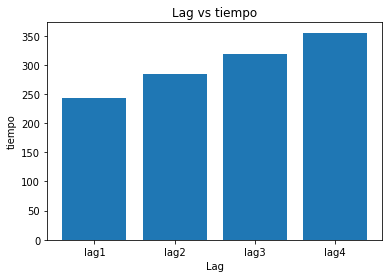

In [57]:
##grafico comparación de tiempo
bar_lag(time_all,'Lag', 'tiempo', 'Lag vs tiempo')

** Grafico de valor de RMSE con respecto  a valor de lag, comparando Train y Test **

[2.7934223916453202, 2.709313369643276, 2.7123380356605984, 2.7328803670919033]

[2.5861783693974485, 2.5022348743990945, 2.51772986031225, 2.5443202145088812]

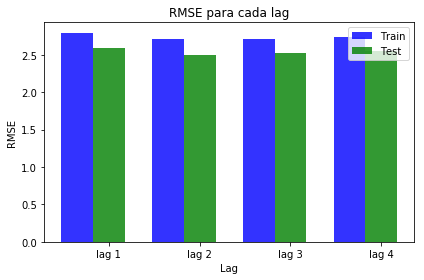

In [58]:
## Grafico RMSE: TrainScore y TestScore
trainScore_lag_all
testScore_lag_all
twobar_lag(trainScore_lag_all,testScore_lag_all,"Train","Test")

** Diagramas de caja para datosd de entrenamiento y prueba **

 El objetivo es tener en una sola mirada la distribución de los datos según cada valor de lag.

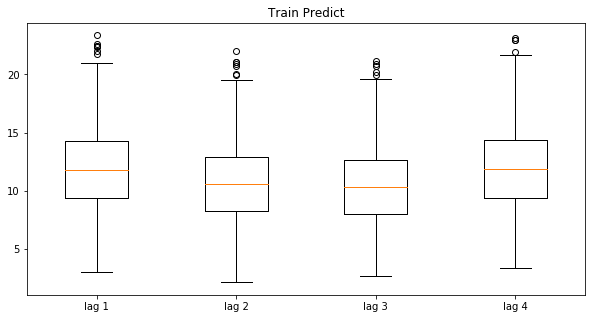

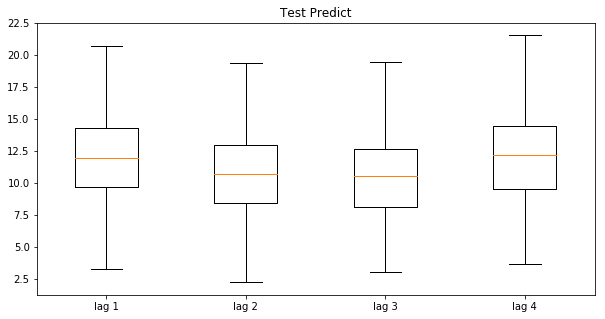

In [59]:
boxplot_data1(trainPredict_lag_all, "Train Predict", 4)
boxplot_data1(testPredict_lag_all, "Test Predict", 4)

** Gráfico de valor de loss para los distintos valores de lag **



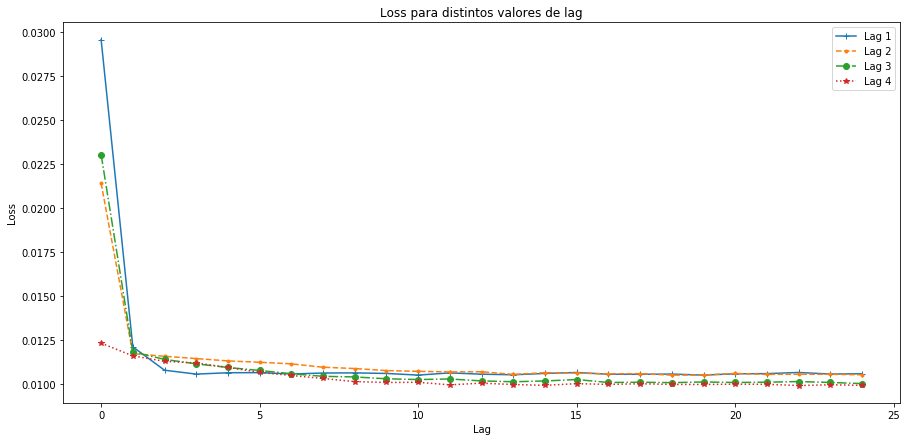

In [60]:
loss_gLinea(history_lag_all,0,4, 1,-2, "Lag", "Loss", "Loss para distintos valores de lag",0, "Lag ") ## REVISAR

** Extracto de gráficos de series de tiempo, para entrenamiento y prueba **

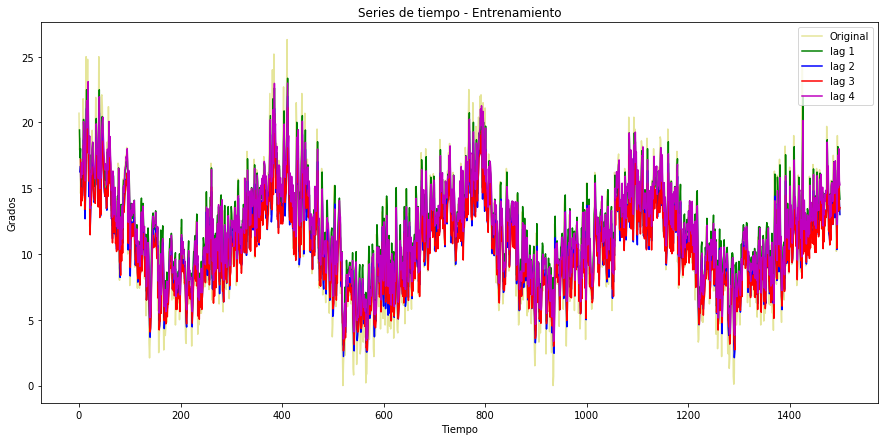

In [61]:
_ = g_timeSeriesMulti([trainPredict_lag_all[0], trainPredict_lag_all[1], trainPredict_lag_all[2], trainPredict_lag_all[3]],
                  ["Original", "lag 1", "lag 2", "lag 3", "lag 4"],
                  "Series de tiempo - Entrenamiento",
                  [mk_shift_A_lag(trainPredict_lag_all[0], 1),
                   mk_shift_A_lag(trainPredict_lag_all[1], 2),
                   mk_shift_A_lag(trainPredict_lag_all[2], 3),
                   mk_shift_A_lag(trainPredict_lag_all[3], 4)],
                  max_x = 1500)

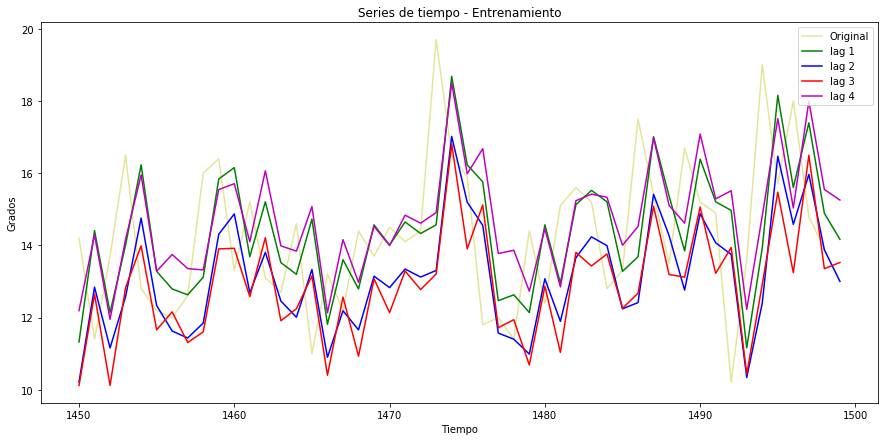

In [62]:
_ = g_timeSeriesMulti([trainPredict_lag_all[0], trainPredict_lag_all[1], trainPredict_lag_all[2], trainPredict_lag_all[3]],
                  ["Original", "lag 1", "lag 2", "lag 3", "lag 4"],
                  "Series de tiempo - Entrenamiento",
                  [mk_shift_A_lag(trainPredict_lag_all[0], 1),
                   mk_shift_A_lag(trainPredict_lag_all[1], 2),
                   mk_shift_A_lag(trainPredict_lag_all[2], 3),
                   mk_shift_A_lag(trainPredict_lag_all[3], 4)],
                   min_x = 1450, max_x = 1500)

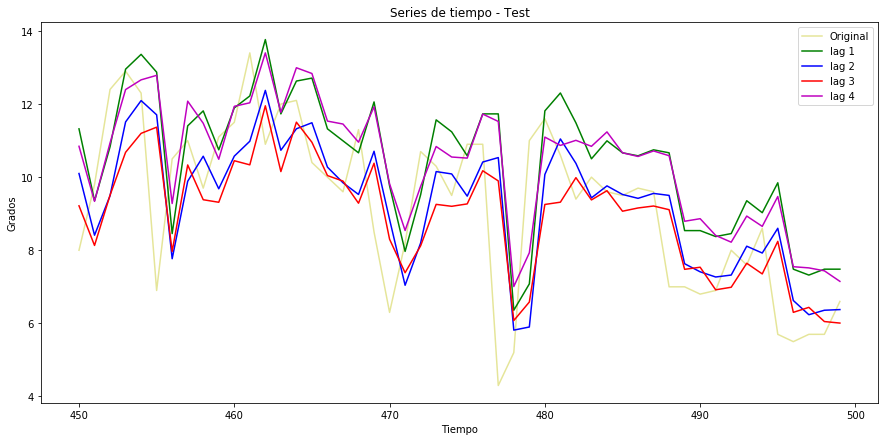

In [63]:
_ = g_timeSeriesMulti([testPredict_lag_all[0], testPredict_lag_all[1], testPredict_lag_all[2], testPredict_lag_all[3]],
                  ["Original", "lag 1", "lag 2", "lag 3", "lag 4"],
                  "Series de tiempo - Test",
                  [mk_shift_A_lag(testPredict_lag_all[0], 1),
                   mk_shift_A_lag(testPredict_lag_all[1], 2),
                   mk_shift_A_lag(testPredict_lag_all[2], 3),
                   mk_shift_A_lag(testPredict_lag_all[3], 4)],
                   min_x = 450, max_x = 500, original_offset = 1500)

In [64]:
## MAX y MIN de RMSE
print("Max RMSE Train %s" % str(np.amax(trainScore_lag_all)))
print("Min RMSE Train %s" % str(np.amin(trainScore_lag_all)))
print("Max RMSE Test  %s" % str(np.amax(testScore_lag_all)))
print("Min RMSE Test  %s" % str(np.amin(testScore_lag_all)))

Max RMSE Train 2.7934223916453202
Min RMSE Train 2.709313369643276
Max RMSE Test  2.5861783693974485
Min RMSE Test  2.5022348743990945


** Comentarios: **

1\.  Tiempo: Se observa en el gráfico barras, que a medida que aumenta el número de lag, aumenta el tiempo.

2\.  Con respecto al valor de RMSE, tanto para entrenamineto como para prueba: 
*   se observa que los valores se mantienen en un rango acotado, aprox. entre 2.70 y 2.79 para los datos de entrenamiento, y para los datos de prueba entre 2.50 y 2.58 aprox.  
* los valores obtenidos para prueba son siempre menores que los obtenidos para entrenamiento.

3\.  Los datos predecidos se presentan en gráficos de cajas, donde se observa que todos tienen una distribución de datos muy similar.

4\.  Con respecto a loss vs lag, se observa que:
* a medida que la aumenta el valor de lag la convergencia es mucho más rápida, es decir con lag = 4.
* Los menores valore de loss en los 25 epochs se obtienen con lag=4, seguida de lag3, y luego lag=1,2. 
* para todos los valores de lag converge en los primeros 10 epochs. 
* con lag=4 en el primer epoch se obtiene el menor valor y con lag=1 el valor más alto.

5\.  Al graficar las series de tiempo-entrenamiento, para lo que se utiliza todo los datos y  extracto de estos para tener mayor detalle.
* se observa que con lag=1 y 4, los datos se encuentran, en muchos casos, por sobre los datos originales, y para la=2 y 3, se encuentran por debajo de los datos originales.
* para todos los casos de lag se tiene un desfase en los datos, manteniendo oscilaciones similares.
* graficamente, los datos que más se asemejan a los datos reales es con lag=2 y lag=4, a pesar de estar por debajo y sobre los datos originales, respectivamente.

### l) Usando un lag de 3, compare el desempeño de la LSTM con una red recurrente simple y una GRU, comente sobre convergencia y tiempo de ejecución

In [65]:
## Red GRU y lag 3

historyGRU = []
lag = 3

trainX_GRU, trainY_GRU, testX_GRU, testY_GRU = createData_TrainTest(lag, stream_train_scaled_Orig, stream_test_scaled_Orig)
trainX_GRU, testX_GRU = data_reshape(trainX_GRU, testX_GRU) ## De acuerdo al modelo i)
print_format(trainX_GRU,trainY_GRU, testX_GRU,testY_GRU)

model_GRU = None
model_GRU = Sequential()
model_GRU.add(GRU(4, input_dim=1, inner_init='orthogonal', activation='tanh')) ## input_dim al elegir opción i)
model_GRU.add(Dense(1,activation='linear'))
model_GRU.compile(loss='mean_squared_error', optimizer='adam')
start_time_GRU = time.time()
historyGRU.append(model_GRU.fit(trainX_GRU, trainY_GRU, epochs=25, batch_size=1, verbose=1))
end_time_GRU = time.time()
timeGRU = end_time_GRU - start_time_GRU
print("Time GRU %s" % str(timeGRU))

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if sys.path[0] == '':
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(4, activation="tanh", input_shape=(None, 1), recurrent_initializer="orthogonal")`
  if sys.path[0] == '':


Epoch 1/25
1497/1497 [==============================] - 15s 10ms/step - loss: 0.0126
Epoch 2/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0109
Epoch 3/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0107
Epoch 4/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0108
Epoch 5/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0105
Epoch 6/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0106
Epoch 7/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0106
Epoch 8/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0106
Epoch 9/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0106
Epoch 10/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0105
Epoch 11/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0106
Epoch 12/25
1497/1497 [==============================] - 14s 9ms/step - l

In [66]:
## Red recurrente simple
historySimpleRNN = []

lag = 3

trainX_sRNN, trainY_sRNN, testX_sRNN, testY_sRNN = createData_TrainTest(lag, stream_train_scaled_Orig, stream_test_scaled_Orig)
trainX_sRNN, testX_sRNN = data_reshape(trainX_sRNN, testX_sRNN) ## De acuerdo al modelo i)
print_format(trainX_sRNN,trainY_sRNN, testX_sRNN,testY_sRNN)

model_sRNN = None
model_sRNN = Sequential()
model_sRNN.add(SimpleRNN(4, input_dim=1, inner_init='orthogonal',activation='tanh')) ## input_dim al elegir opción i)
model_sRNN.add(Dense(1,activation='linear'))
model_sRNN.compile(loss='mean_squared_error', optimizer='adam')
start_time_SimpleRNN = time.time()
historySimpleRNN.append(model_sRNN.fit(trainX_sRNN, trainY_sRNN, epochs=25, batch_size=1, verbose=1))
end_time_SimpleRNN = time.time()

timeSimpleRNN = end_time_SimpleRNN - start_time_SimpleRNN

print("Time SimpleRNN %s" % str(timeSimpleRNN ))

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)
Epoch 1/25


/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if sys.path[0] == '':
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(4, activation="tanh", input_shape=(None, 1), recurrent_initializer="orthogonal")`
  if sys.path[0] == '':


1497/1497 [==============================] - 10s 7ms/step - loss: 0.0667
Epoch 2/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0130
Epoch 3/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0107
Epoch 4/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0103
Epoch 5/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0103
Epoch 6/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0102
Epoch 7/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0102
Epoch 8/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0103
Epoch 9/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0102
Epoch 10/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0103
Epoch 11/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0103
Epoch 12/25
1497/1497 [==============================] - 8s 6ms/step - loss: 0.0102
Epoch 13/25

** Observación:** Para la red demo modelo i), se utiliza la entrenada anteriormente

In [67]:
print("Tiempo de ejecución")
print("\tTiempo GRU %f" % (timeGRU))
print("\tTiempo SimpleRNN %f" % (timeSimpleRNN))
print("\tTiempo LSTM %f" % ((time_i)))

Tiempo de ejecución
	Tiempo GRU 343.317057
	Tiempo SimpleRNN 210.685945
	Tiempo LSTM 308.728830


** Comentarios:** La red que tiene mejor de ejeución es la red SimpleRNN, seguida de LSTM y la peor es GRU.

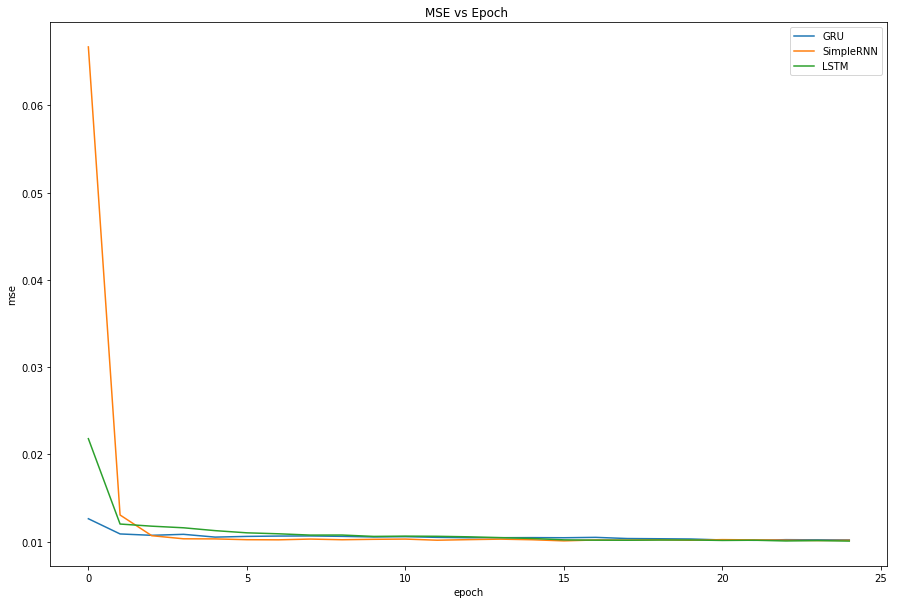

In [68]:
## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
_ = plt.close('all')
_ = plt.figure(figsize=(15,10))
_ = plt.title('MSE vs Epoch ')
_ = plt.plot(historyGRU[0].history['loss'])
_ = plt.plot(historySimpleRNN[0].history['loss'])
_ = plt.plot(history_i[0].history['loss'])
_ = plt.xlabel('epoch')
_ = plt.ylabel('mse')
_ = plt.legend(['GRU','SimpleRNN', 'LSTM'], loc='upper right')
plt.show()

** Comentarios** Con respecto al tiempo de convergencia se observa:
* la red SimpleRNN parte con el peor error, por sobre 0.06, luego viene LSMT que parte con un error pasado los 0.02 y finalmente la mejor es GRU que parte con un error aprox 0.015.
* En los últimos 5 epochs, los resultados son casi indistinguibles.
* Todas las redes tienen una disminución considerable de error en los primer 5 epochs.
* La red GRU es la que presenta mejor desempeño durante todos los epochs, esto puede estar asociado a que utiliza mayor tiempo de entrenamiento.


# m) Entrenando la red con memoria entre batches. Gráfico de predicción, comentarios con respecto a si mejora la predicción

In [69]:
## Se utiliza modelo de i)
lag = 3
history_epoch_all_m= []
time_all_m = []

#Datos y forma deseada
trainX_m, trainY_m, testX_m, testY_m = createData_TrainTest(lag, stream_train_scaled_Orig, stream_test_scaled_Orig)
trainX_m, testX_m = data_reshape(trainX_m, testX_m) ## De acuerdo al modelo i)
print_format(trainX_m,trainY_m, testX_m,testY_m)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)


In [70]:
lag = 3
batch_size = 1
model_m = None
model_m = Sequential()
model_m.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model_m.add(Dense(1,activation='linear'))
model_m.compile(loss='mean_squared_error', optimizer='adam')
start_time_m = time.time()
for i in range(25): 
    #entrenar
    start_time = time.time()
    hist = model_m.fit(trainX_m, trainY_m, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    end_time = time.time()
    model_m.reset_states()  #clears only thehidden states of the network
    history_epoch_all_m.append(hist.history['loss'])
    time_all_m.append(end_time-start_time)
end_time_m = time.time()    
time_m = end_time_m - start_time_m    
## Memoria entre batches corresponde al estado oculto de la red LSTM.
## Se entrena con batch_size=1, es decir de 1 ejemplo - estado oculto de 1 ejemplo que es la entrada al siguiente.
## (shuffle=False), indica que se entrena de forma ordenada.

Epoch 1/1
1497/1497 [==============================] - 15s 10ms/step - loss: 0.0212
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0110
Epoch 1/1
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0110
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0109
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0107
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0104
Epoch 1/1
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0099
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0095
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0094
Epo

In [71]:
print_format(trainX_m,trainY_m, testX_m,testY_m)
## Predecir
trainPredict_m, trainY_inv_m, testPredict_m, testY_inv_m = predict(trainX_m,trainY_m, testX_m, testY_m,batch_size, model_m)
##Cálculo de root mean square error
trainScore_m,testScore_m = cal_RMSE(trainY_inv_m,trainPredict_m, testY_inv_m,testPredict_m)  

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)
Train Score: 2.98 RMSE
Test Score: 2.77 RMSE


In [72]:
##RMSE para modelo i) 
print("RMSE Modelo i)")
print("Train %s" % str(trainScore_i))
print("Test  %s" % str(testScore_i))

RMSE Modelo i)
Train 2.6323652809021625
Test  2.429142858503236


** Comentario ** Se observa que se obtienen valores más grandes de RMSE, con respecto al modelo i).

** A continuación se presentan tres gráficos de series de tiempo para los datos de predicción, en todos los casos se compara con los datos originales**
* Serie de tiempo considerando todos los datos.
* Series de tiempo para datos de entrenamiento comparado con el modelo i)
* Extracto de gráfico de 1350 a  1600, para los datos de entrenamiento y prueba, comparado con el modelo i)

Luego de los gráficos se presentan las conclusiones.

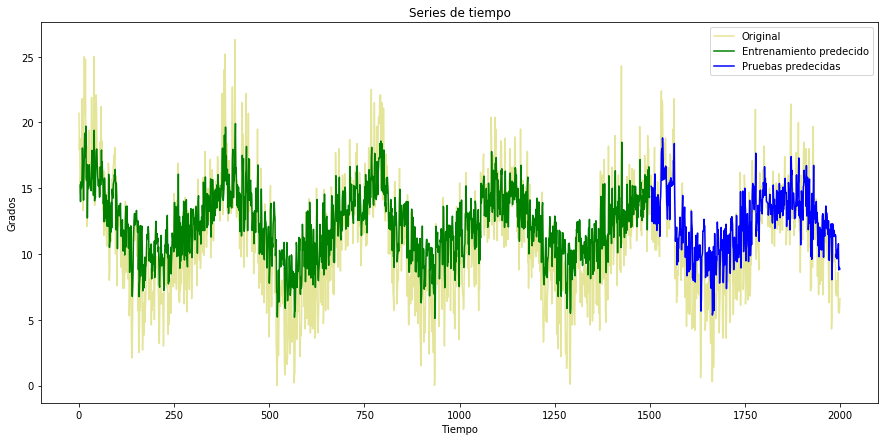

In [73]:
_ = g_timeSeriesMulti([trainPredict_m, testPredict_m],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo",
                  [mk_shift_A_lag(trainPredict_m, 3), mk_shift_B_lag(trainPredict_m, 3)]
                  )

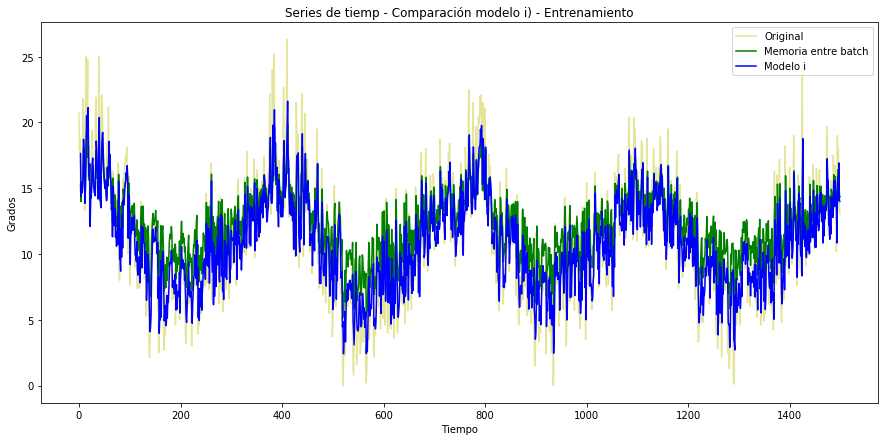

In [74]:
_ = g_timeSeriesMulti([trainPredict_m, trainPredict_i],
                  ["Original", "Memoria entre batch", "Modelo i"],
                  "Series de tiemp - Comparación modelo i) - Entrenamiento",
                  [mk_shift_A_lag(trainPredict_m, 3), mk_shift_A_lag(trainPredict_i, 3)],
                  max_x = 1500
                  )

** Extracto de gráfico **

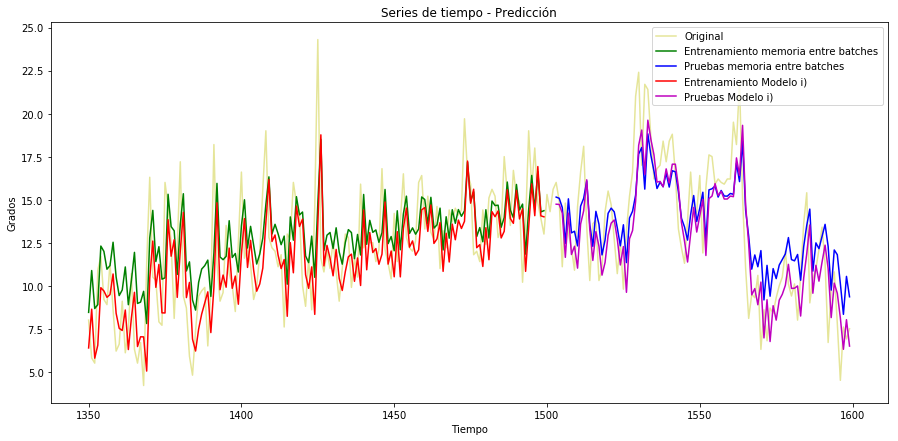

In [75]:
_ = g_timeSeriesMulti([trainPredict_m, testPredict_m, trainPredict_i, testPredict_i],
                  ["Original", "Entrenamiento memoria entre batches", "Pruebas memoria entre batches",
                   "Entrenamiento Modelo i)","Pruebas Modelo i)" ],
                  "Series de tiempo - Predicción",
                  [mk_shift_A_lag(trainPredict_m, 3), mk_shift_B_lag(trainPredict_m, 3), 
                   mk_shift_A_lag(trainPredict_i, 3), mk_shift_B_lag(trainPredict_i, 3)],
                  min_x = 1350, max_x = 1600
                  )

** Comentarios**

* Como se menciono anteriormente, de acuerdo al valor obtenido en RMSE, se obtienen peores resultados, con respecto al modelo i), por lo que la predicción no mejora con memoria entre batches.

* En los graficos de predicción, se puede observar como los datos tienen un desfase y en algunos casos esta por sobre los datos originales, sin embargo pareciera ser que en algunos casos están más cerca de los datos originales.

### n) Comparar resultados anterior usando un tamaño de batch a elección, mayor o igual a 3


Se elige batch=3

In [76]:
## Como el total de muestras se divide por el número de batchs, se eliminan
##algunas muestras (ultimos datos) para que el total sea divisible por el número de batches.

test_delete = np.copy(stream_test_scaled_Orig)
test_delete = np.delete(test_delete, 499, axis = 0)
test_delete = np.delete(test_delete, 498, axis = 0)
test_delete.shape

#trainX, trainY, testX, testY = data_batch(lag, train_delete, test_delete)
#Datos y forma deseada
lag = 3
trainX_n, trainY_n, testX_n, testY_n = createData_TrainTest(lag, stream_train_scaled_Orig, test_delete)
trainX_n, testX_n = data_reshape(trainX_n, testX_n) ## De acuerdo al modelo i)
print_format(trainX_n,trainY_n, testX_n,testY_n)

(498, 1)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (495, 3, 1)
TestY (495,)


In [77]:
## Se utiliza modelo de i) y batch_size=3
history_epoch_all_n= []
time_all_n = []
lag = 3
batch_size = 3
#Datos y forma deseada

model_n = None
model_n = Sequential()
model_n.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model_n.add(Dense(1,activation='linear'))
model_n.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25): 
    #entrenar
    start_time = time.time()
    hist = model_n.fit(trainX_n, trainY_n, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    end_time = time.time()
    
    model_n.reset_states() 
    
    history_epoch_all_n.append(hist.history['loss'])
    time_all_n.append(end_time-start_time)

Epoch 1/1
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0194
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0122
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0118
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0115
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0114
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0113
Epoch 1/1
1497/1497 [==============================] - 5s 3ms/step - loss: 0.0112
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0110
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0109
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0108
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0107
Epoch 1/1
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0106
Epoch 1/1
1497/1

In [78]:
## Predecir
trainPredict_n, trainY_inv_n, testPredict_n, testY_inv_n = predict(trainX_n,trainY_n, testX_n, testY_n,batch_size, model_n)
##Cálculo de root mean square error
trainScore_n,testScore_n = cal_RMSE(trainY_inv_n,trainPredict_n, testY_inv_n,testPredict_n)  
#clears only thehidden states of the network

Train Score: 2.67 RMSE
Test Score: 2.49 RMSE


In [79]:
##RMSE para modelo i) 
print("RMSE Modelo i)")
print("Train %s" % str(trainScore_i))
print("Test  %s" % str(testScore_i))

print("RMSE Modelo n)")
print("Train %s" % str(trainScore_n))
print("Test  %s" % str(testScore_n))

print("RMSE Modelo m)")
print("Train %s" % str(trainScore_m))
print("Test  %s" % str(testScore_m))

RMSE Modelo i)
Train 2.6323652809021625
Test  2.429142858503236
RMSE Modelo n)
Train 2.6737973917729887
Test  2.492276369694503
RMSE Modelo m)
Train 2.97538958290745
Test  2.7668003131957777


** Comentatarios** Con el modelo i) se obtienen los mejores resultados para RMSE, seguido de memoria entre batch = 3 y finalmente memoria entre batch=1.

In [80]:
## Tiempo de ejecución, para el caso de modelo m y n, se utiliza el promedio ya que se entrenan 25 veces
##RMSE para modelo i) 
print("Tiempo Modelo i)")
print("Train %s" % str(time_i))

print("Tiempo Modelo n)")
print("Train %s" % str(np.mean(time_all_n)))

print("Tiempo Modelo m)")
print("Train %s" % str(np.mean(time_all_m)))

Tiempo Modelo i)
Train 308.7288296222687
Tiempo Modelo n)
Train 4.4963851737976075
Tiempo Modelo m)
Train 13.515466861724853


** Comentarios**
* Para el caso del modelo m y n, se utiliza el promedio de todos los tiempos de entrenamientos. Dado que el modelo es uno sólo que se entrena varias veces, eliminando en cada iteración los valores de las capas ocultas.
* Los tiempos con memoria entre batches son muy distintos a los del modelo i). El modelo n) es 98% más rápido que el modelo i), y el modelo m) es 95,6% más rápido.

### Gráficos de series de tiempo
* Todos los datos predecidos, entrenamiento y prueba
* Datos de entrenamiento, para: batch=1, batch=3 y modelo i)
* Extracto de gráfico para datos entre 1450 a 1500, para datos de entrenamiento, con: batch=1, batch=3 y modelo i)

Luego de los gráficos se presentan las conclusiones.

In [81]:
## Se agregan dos datos al final de testPredict, dado que se eliminaron 2 al comienzo, para graficar.
testPredict_n = np.append(testPredict_n,None, 498)
testPredict_n = np.append(testPredict_n,None, 499)

In [82]:
testPredict_n = np.reshape(testPredict_n,(testPredict_n.shape[0],1))

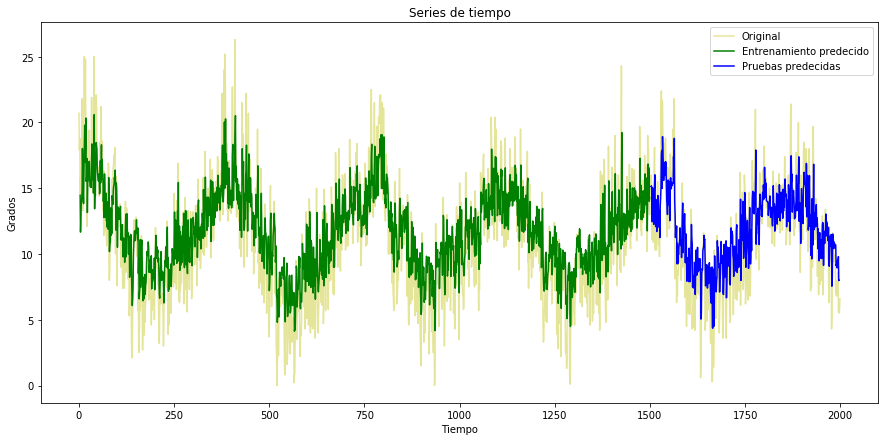

In [83]:
_ = g_timeSeriesMulti([trainPredict_n, testPredict_n],
                  ["Original", "Entrenamiento predecido", "Pruebas predecidas"],
                  "Series de tiempo",
                  [mk_shift_A_lag(trainPredict_n, 3), mk_shift_B_lag(trainPredict_n, 3)]                  
                  )

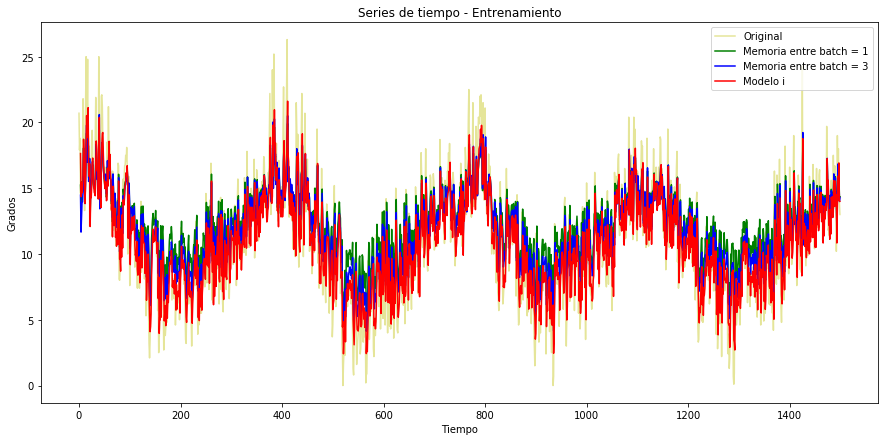

In [84]:
_ = g_timeSeriesMulti([trainPredict_m, trainPredict_n, trainPredict_i],
                  ["Original", "Memoria entre batch = 1", "Memoria entre batch = 3", "Modelo i"],
                  "Series de tiempo - Entrenamiento",
                  [mk_shift_A_lag(trainPredict_n, 3), mk_shift_A_lag(trainPredict_n, 3),
                   mk_shift_A_lag(trainPredict_i, 3)],
                  max_x = 1500
                  )

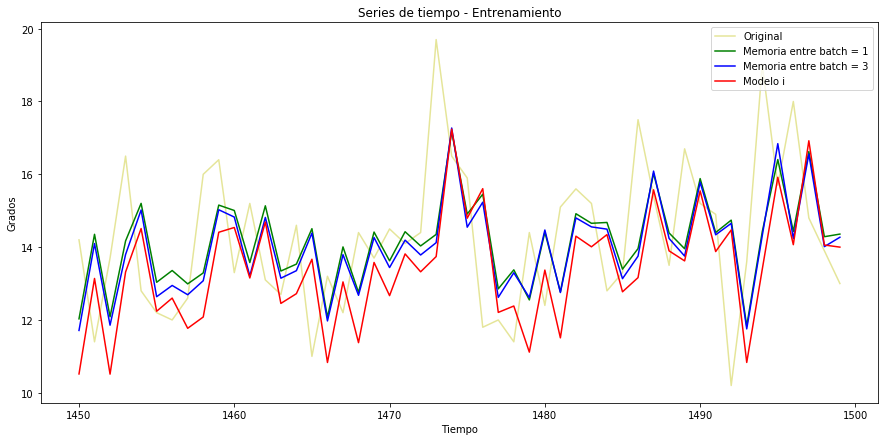

In [85]:
_ = g_timeSeriesMulti([trainPredict_m, trainPredict_n, trainPredict_i],
                  ["Original", "Memoria entre batch = 1", "Memoria entre batch = 3", "Modelo i"],
                  "Series de tiempo - Entrenamiento",
                  [mk_shift_A_lag(trainPredict_n, 3), mk_shift_A_lag(trainPredict_n, 3), 
                   mk_shift_A_lag(trainPredict_i, 3)],
                  min_x = 1450, max_x = 1500
                  )

** Comentarios**

* Se observa que los datos obtenidos con el modelo con memoria entre batch se asemejan más a los datos originales, que los datos del modelo i).
* Los datos obtenidos con el modelo con batch=1 se van entrelazando con los datos obtenidos del modelo con batch=3, por lo que es difícil gráficamente determinar cual es mejor. Sin embargo, como ya se concoce que el valor de RMSE es mejor para el modelo con batch=3 que con batch=1, se opta por este modelo.

** Gráfico de mse vs epochs **

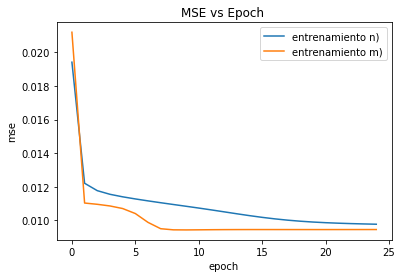

In [86]:
_ = plt.close('all')
_ = plt.title('MSE vs Epoch ')
_ = plt.plot(history_epoch_all_n)
_ = plt.plot(history_epoch_all_m)
_ = plt.xlabel('epoch')
_ = plt.ylabel('mse')
_ = plt.legend(['entrenamiento n)', 'entrenamiento m)'], loc='upper right')

** Comentarios **

Se observa que el modelo con batch=1 tiene mejor convergencia que el modelo con batch=3.

### o) LSTM apilada, y comparacion con modelo de i). Comentarios

La imagen a continuación permite entender las dos opciones para que la red apilada se pueda alimentar. Para el modelo a continuación se utiliza TRUE.

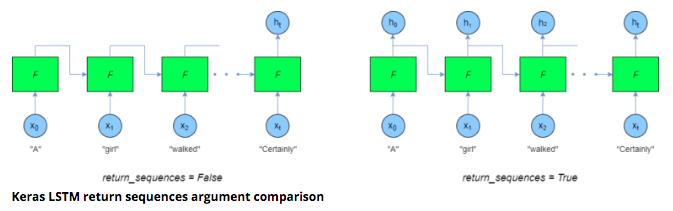

In [87]:
Image("return_sequences.png")

In [88]:
stream_train_scaled_Orig.shape
stream_test_scaled_Orig.shape

(1500, 1)

(500, 1)

In [89]:
lag = 3
batch_size = 1

trainX_o, trainY_o, testX_o, testY_o = createData_TrainTest(lag, stream_train_scaled_Orig, stream_test_scaled_Orig)
trainX_o, testX_o = data_reshape(trainX_o, testX_o) ## De acuerdo al modelo i)
print_format(trainX_o,trainY_o, testX_o,testY_o)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)


In [99]:
#una capa de entrada
## (nodos/neuronas en las capas ocultas dentro de la celda LSTM ej. número de celdas en la capa forget, input, ..., 
## return _sequences = TRUE, asegura que la celda LSTM devuelva todas las salidas de la celda LSTM desenrrolladas a lo largo del tiempo.
## Si se omite este argumento, la celda LSTM simplemente proporcionaá la salida de la celda LSTM desde el ultimo paso de tiempo
# un capa de salida

In [90]:
history_o = []

model_o = None
model_o = Sequential()
model_o.add(LSTM(4, input_dim=1, return_sequences=True))
model_o.add(LSTM(4))
model_o.add(Dense(1,activation='linear'))
model_o.compile(loss='mean_squared_error', optimizer='adam')
start_time_o = time.time()
history_o.append(model_o.fit(trainX_o, trainY_o, epochs=25, batch_size=1, verbose=1)) ## cambiar epochs a 25
end_time_o = time.time()

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, return_sequences=True, input_shape=(None, 1))`
  """


Epoch 1/25
1497/1497 [==============================] - 28s 19ms/step - loss: 0.0290
Epoch 2/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0134
Epoch 3/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0128
Epoch 4/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0123
Epoch 5/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0117
Epoch 6/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0113
Epoch 7/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0109
Epoch 8/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0109
Epoch 9/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0106
Epoch 10/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0105
Epoch 11/25
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0104
Epoch 12/25
1497/1497 [==============================] - 25s 17

** Observación:** Para el modelo i) se utilizan los datos ya entrenados.

In [91]:
time_o = end_time_o - start_time_o
print("Tiempo de ejecución ", time_o )

Tiempo de ejecución  631.2810714244843


** Comentarios** El tiempo de entrenamiento de modelo i) es de  308.728830 seg, que es la mitad del tiempo que se demoro la red LSTM apilada.

In [92]:
## Predecir
trainPredict_o, trainY_inv_o, testPredict_o, testY_inv_o = predict(trainX_o,trainY_o, testX_o, testY_o,batch_size, model_o)

In [93]:
##Cálculo de root mean square error
trainScore_o,testScore_o = cal_RMSE(trainY_inv_o,trainPredict_o, testY_inv_o,testPredict_o)

Train Score: 2.77 RMSE
Test Score: 2.58 RMSE


Obs. En celdas más abajo se presenta la comparación con modelo i).

### Gráficos de series de tiempo
* Todos los datos para red LSTM apilada y Modelo i)
* Extracto de datos para red LSTM apilada y Modelo i)

Luego de los gráficos se presenta comentatios y conclusión.

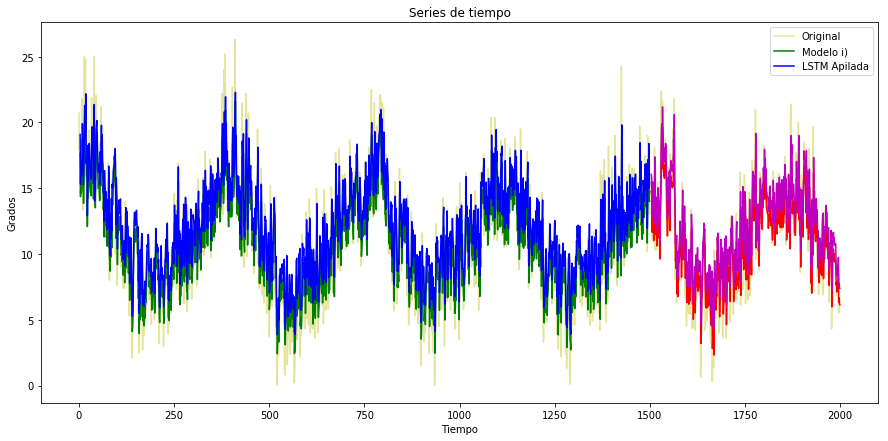

In [94]:
_ = g_timeSeriesMulti([trainPredict_i, trainPredict_o, testPredict_i, testPredict_o],
                  ["Original", "Modelo i)", "LSTM Apilada"],
                  "Series de tiempo",
                  [mk_shift_A_lag(trainPredict_i, 3), mk_shift_A_lag(trainPredict_o, 3),
                   mk_shift_B_lag(trainPredict_i, 3), mk_shift_B_lag(trainPredict_o, 3)]
                  )

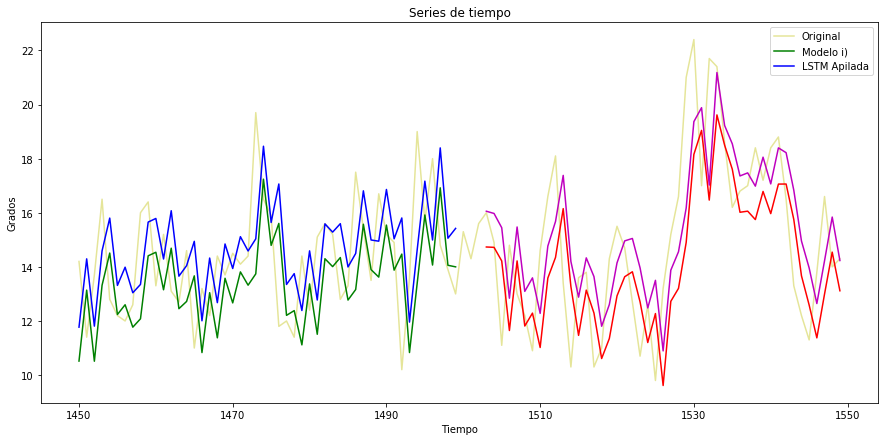

In [95]:
_ = g_timeSeriesMulti([trainPredict_i, trainPredict_o, testPredict_i, testPredict_o],
                  ["Original", "Modelo i)", "LSTM Apilada"],
                  "Series de tiempo",
                  [mk_shift_A_lag(trainPredict_i, 3), mk_shift_A_lag(trainPredict_o, 3),
                   mk_shift_B_lag(trainPredict_i, 3), mk_shift_B_lag(trainPredict_o, 3)],
                   min_x = 1450, max_x = 1550
                  )

** Comentarios**

Se observa que con los datos de la red LSTM apilada los datos se acercan mucho más a los datos originales que los datos del modelo i).

In [96]:
##RMSE para modelo i) 
print("RMSE Modelo i)")
print("Train %s" % str(trainScore_i))
print("Test  %s" % str(testScore_i))

print("RMSE Modelo o)")
print("Train %s" % str(trainScore_o))
print("Test  %s" % str(testScore_o))

RMSE Modelo i)
Train 2.6323652809021625
Test  2.429142858503236
RMSE Modelo o)
Train 2.766972214521575
Test  2.580231584317085


** Comentarios** La red LSTM apilada tiene valores más altos de RMSE que el modelo i).

### Gráfico de mse vs epochs

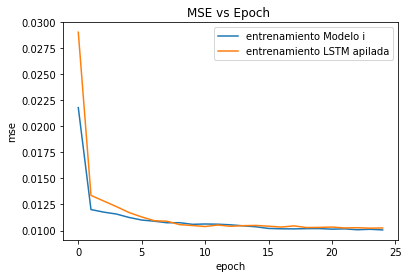

In [97]:
    _ = plt.close('all')
    _ = plt.title('MSE vs Epoch ')
    _ = plt.plot(history_i[0].history['loss'])
    _ = plt.plot(history_o[0].history['loss'])
    _ = plt.xlabel('epoch')
    _ = plt.ylabel('mse')
    _ = plt.legend(['entrenamiento Modelo i','entrenamiento LSTM apilada'], loc='upper right')

** Comentarios** Se observa que en los primeros 5 epochs la red converge un poco más lento que el modeo i), pero luego de los 5 epochs mantienen el mismo comportamiento.

In [98]:
##Compración de tiempos

print("Modelo i)", time_i)
print("Modelo o)", time_o)

Modelo i) 308.7288296222687
Modelo o) 631.2810714244843


### p) Sobre red definidas anteriormente se gráfica el valor real *vs* la predicción del conjunto de pruebas tomando el primer dato (con sus $t$ *timesteps*) como inicio de la predicción y luego para predecir el siguiente valor se toman los $t-1$ *timesteps* mas el valor de predicción del primer dato, y así hasta cubrir todos los datos de pruebas. Dicho de otra forma, para los $N_t$ datos/mediciones del conjunto de pruebas, se requiere predecir los $N_t-t$ valores a partir de algun valor $p$, de la siguiente manera:
$$
\hat{x}_{p} = f(x_{p-t},x_{p-t+1},\cdots,x_{p-1}) \\
\hat{x}_{p+1} = f(x_{p+1-t},x_{p+1-t+1},\cdots,x_{p-1},\hat{x}_{p}) \\
\hat{x}_{p+2} = f(x_{p+2-t},x_{p+2-t+1},\cdots,\hat{x}_{p},\hat{x}_{p+1}) \\
\cdots \\
\hat{x}_{N_t} = f(\hat{x}_{N_t-t},\hat{x}_{N_t-t+1},\cdots,\hat{x}_{N_t-2},\hat{x}_{N_t-1})
$$

In [100]:
lag = 3
trainX, trainY, testX, testY = createData_TrainTest(lag, stream_train_scaled, stream_test_scaled)
trainX, testX = data_reshape(trainX, testX)
print_format(trainX,trainY,testX, testY)
print_data(trainX, testX)

TrainX (1497, 3, 1)
TrainY (1497,)
TestX (497, 3, 1)
TestY (497,)
Data [[[0.7870723]
  [0.6806084]
  [0.7148289]]

 [[0.6806084]
  [0.7148289]
  [0.5551331]]

 [[0.7148289]
  [0.5551331]
  [0.6007605]]

 ...

 [[0.7224335]
  [0.5969582]
  [0.6844107]]

 [[0.5969582]
  [0.6844107]
  [0.5627377]]

 [[0.6844107]
  [0.5627377]
  [0.5285171]]]

Data [[[0.5817491 ]
  [0.54372627]
  [0.5931559 ]]

 [[0.54372627]
  [0.5931559 ]
  [0.60836506]]

 [[0.5931559 ]
  [0.60836506]
  [0.56653994]]

 ...

 [[0.32699624]
  [0.21673004]
  [0.20912549]]

 [[0.21673004]
  [0.20912549]
  [0.21673004]]

 [[0.20912549]
  [0.21673004]
  [0.21673004]]]



Función generadora para los datos que se consideran en la predicción

In [101]:
def generarDatoP():
    for i in range(testX.shape[0]):
        dato_i = testX[i]        
        dato_i = np.reshape(dato_i, (1, dato_i.shape[0], dato_i.shape[1]))        
        yield dato_i

Funión que reemplaza el último dato por el dato predecido.

In [102]:
def ajustarDato(_d, _datoPredicho):
    _dd = np.copy(_d)
    _dd[0][2] = _datoPredicho
    return _dd

In [103]:
primerDato = True
resultados = []
for _d in generarDatoP():    
    #print("_d:\n%s" % _d)
    if primerDato:
        dato = _d
        primerDato = False
    else:
        dato = ajustarDato(_d, datoPredicho)        
    #print("dato:\n%s" % dato)
        
    datoPredicho = model_i.predict(dato, batch_size=1) ## Se utiliza el modelo de la pregunta i)
    
    #print("dato predicho:\n%s" % datoPredicho)
    resultados.append([datoPredicho[0][0]])
resultados = np.asarray(resultados)

### Gráfico de predicción para los datos de prueba

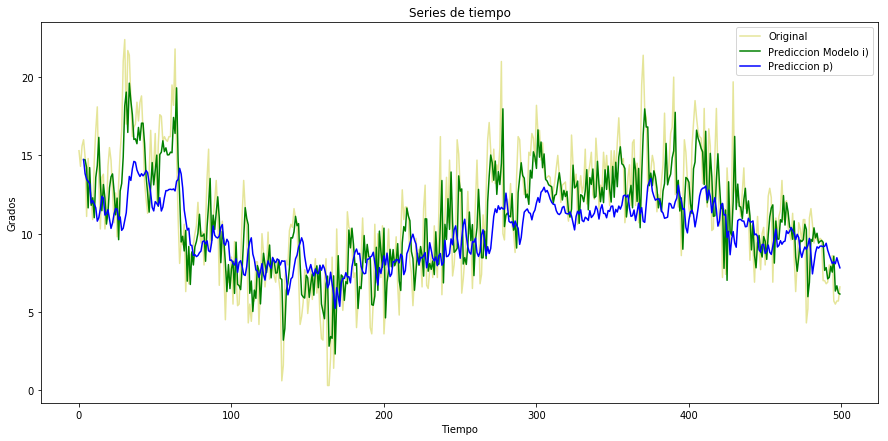

In [104]:
scaled_resultados = scaler.inverse_transform(resultados)

_ = g_timeSeriesMulti([testPredict_i, scaled_resultados],
                  ["Original", "Prediccion Modelo i)", "Prediccion p)"],
                  "Series de tiempo",
                  [mk_shift_A_lag(testPredict_i,3), mk_shift_A_lag(scaled_resultados,3)],
                   #min_x = 450, max_x = 500, 
                  original_offset = 1500   
                  )

** Comentarios**
* Como se observa en el gráfico, la predicción empeora con respecto al modelo i).
* Y, a medida que se van considerando más datos predichos para predecir los siguientes, la predicción va empeorando.